In [89]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
from matplotlib import colors as clr
import numpy as np
import sys
import re
import fileinput
from scipy.optimize import curve_fit
import operator
#import scipy as scp


# function to change OUTPUT file into space-separated float fields and parameterise the data using this new format
# line in 'with open' bit is type 'str'

# create a function to get spectral grid data

oldstr = ['0-','1-','2-','3-','4-','5-','6-','7-','8-','9-']
newstr = ['0 -','1 -','2 -','3 -','4 -','5 -','6 -','7 -','8 -','9 -']

def data_read_gaia(f):
    missed_line_inds = []
    temp_data = []
    check = 0
    #number of lines to cut = number of line containing 'convective shell' label - (2 + any additional string lines)
    for line in f:
        for i in range(len(oldstr)):
            line = line.replace(oldstr[i],newstr[i])
        check = check + 1
        for x in range(4,1,-1):
            line = line.replace((x*' '),' ')
        line = line.replace('D','E')
        match_ast = re.search('[**]', line)
        match_inf = re.search('Infinity',line)
        if match_ast or match_inf or (line.strip()==''):
            missed_line_inds.append(check)
            #continue
        else:
            file_data = np.array([float(parameter) for parameter in line.strip().split(' ')])
            temp_data.append(file_data)
    out_all_data = np.array(temp_data)

    print 'Total dataset: ',out_all_data.shape
    return out_all_data

# select the parameter (Teff or log(g) for each array(file)) with which to analyse the filter profiles,
# by setting the other to be constant, using the column number (integer)
def grid_vals_dict(input_arr,col_numb):
    col_vals = []
    col_var_arrs = {}
    # create list of values of the column NOT being examined
    for i in range(len(input_arr[:,(col_numb - 1)])):
        if (input_arr[i,(col_numb - 1)] not in col_vals):
            col_vals.append(input_arr[i,(col_numb - 1)])
    print 'Table column ',col_numb,' values list: ',col_vals
    # create arrays for fixed values of col_numb parameter
    for j in col_vals:
        temp_k_list = []
        for k in range(len(input_arr[:,(col_numb - 1)])):
            if (input_arr[k,(col_numb - 1)] == j):
                temp_k_list.append(input_arr[k,:])
        temp_k_array = np.array(temp_k_list)
        #print 'For column',col_numb,'value of',j,', the array has the following shape: ',temp_k_array.shape
        col_var_arrs[str(j)] = temp_k_array
    print 'Final dictionary length: ',len(col_var_arrs)
    return col_var_arrs, col_vals

   
def diff_grid_dict(dict_Av0,dict_Avne0):
    diff_dict = {}
    # use sets to match keys in dictionaries
    combined_set = set(dict_Av0).intersection(set(dict_Avne0))
    print 'combined set size:',len(combined_set)
    for key_val in combined_set:
        #print key_val
        # use variables to store each key value
        Av0_arr_kv = dict_Av0[key_val]
        Avne0_arr_kv = dict_Avne0[key_val]
        # take the difference of the two sets of filter magnitudes for different calibrations of BCs
        # gives absolute extinction A(X) as numerical output
        diff_arr_kv = Av0_arr_kv - Avne0_arr_kv
        for n in range(len(diff_arr_kv[0,:])):
            if (n == 0 or n == 1):
                # these columns are Teff, log(g) - the inputs for the grid - need to reset these to recover grid
                diff_arr_kv[:,n] = Av0_arr_kv[:,n]
        diff_dict[key_val] = diff_arr_kv
        if (diff_arr_kv.shape != Avne0_arr_kv.shape):
            print 'shape error'
    print 'Raw A(X) dictionary complete'
    return diff_dict

# check Casagrande dictionary - is it just the same as before? Shouldn't be!
def casa_check(A_X_dict,casa_A_X_dict,casa_Teff):
    diff_dict = {}
    offset_arr = []
    temp_arr = []
    combined_set = set(A_X_dict).intersection(set(casa_A_X_dict))
    print 'combined set size:',len(combined_set)
    for key_val in combined_set:
        A_arr_kv = A_X_dict[key_val]
        casa_arr_kv = casa_A_X_dict[key_val]
        for m in range(len(A_arr_kv[:,0])):
            for n in range(len(casa_arr_kv[:,0])):
                # these columns are Teff, log(g) - the inputs for the grid - need to reset these to recover grid
                if ((casa_arr_kv[n,0] == A_arr_kv[m,0] and casa_arr_kv[n,1] == A_arr_kv[m,1])):
                    offset_arr.append(casa_arr_kv[n,0])
                    offset_arr.append(casa_arr_kv[n,1])
                    for j in range(2,5):
                        offset_arr.append(casa_arr_kv[n,j] - A_arr_kv[m,j])
                    temp_arr.append(offset_arr)
        diff_dict[key_val] = np.array(temp_arr)
    return diff_dict
    
# general fits write-out function

def general_fit_number_gen_write(f,func_type,func_coeffs,covar_matrix,filter_str,logg_val,avg_dict):
    frac_list = []
    output_names = ['    Fit coefficients (in order of functions'' arguments):','    Covariance matrix:']
    f.write('Fitting results for ' + str(filter_str) + ' filter, with log(g) = ' + str(logg_val) + '\n')
    f.write('Function type:  ' + func_type + '\n')
    f.write(output_names[0] + '\n')
    f.write(str(func_coeffs) + '\n')
    f.write(output_names[1] + '\n')
    f.write(str(covar_matrix) + '\n')
    f.write('Fractional errors in fit coefficients = {E[(X(i)-E[X(i)])*(X(j)-E[X(j)])]}/{|E[X(i)]*E[X(j)]|}' + '\n')
    f.write('i.e., covariance(i,j)/{coef(i)*coef(j)}' + 2*'\n')
    f.write('Fractional error output:  ' + '\n')
    # write out errors as detailed above
    
    sum_y = 0
    yterm_count = 0
    for i in range(len(func_coeffs)):
        f.write('row ' + str(i+1) + 2*'\t')
        for j in range(len(func_coeffs)):
            # use if statement to avoid repeating terms in symmetrical covariance matrix
            # should result in increasing number of entries for increasing row number
            if (j <= i):
                y = abs(covar_matrix[i][j]/(func_coeffs[i]*func_coeffs[j]))
                f.write(str(y) + '\t')
                yterm_count += 1
                sum_y += y
        f.write('\n')
    f.write('\n')
    avg_y = sum_y/yterm_count
    avg_dict[func_type] = avg_y
    f.write('Average fractional error = ' + str(avg_y) + 2*'\n')
    print 'Average fractional error for ' + func_type + ' = ' + str(avg_y)
    
# Modelling functions below!!!

# linear function
def linear_func(xdata,a,b):
    y = (a*xdata) + b
    return y

# quadratic function
def quad_func(xdata,a,b,c):
    y = a*(xdata**2) + (b*xdata) + c
    return y

# single power-law term
def single_poly(xdata,a,b,c):
    y = a*(xdata**b) + c
    return y

# exponential function
def exp_func(xdata,a,b,c):
    y = (a*(np.exp(b*xdata))) + c
    return y

# logarithmic function
def log_func(xdata,a,b,c):
    y = (a*(np.log10(b*xdata))) + c
    return y

# need to combine some effects of Teff, log(g)
# use Teff-keyed dictionaries as the dataset
def from_keys_get_numerical_data(input_dict):
    key_vals_list = []
    for key in sorted(input_dict.iterkeys()):
        float_key = float(key)
        key_vals_list.append(float_key)
    
    key_vals_arr = np.array(key_vals_list)
    print 'Array of key values: ', key_vals_arr.shape
    return key_vals_arr
    
def Teff_logg_product_func(Tdata,gdata,a,b,c):
    y = a*(Tdata*gdata) + b*(gdata**2) + c
    return y

# exponential function added to Teff^d
#def single_poly_plus_exp_func(xdata,a,b,c,d):
#    y = (xdata**d) + (a*(np.exp(b*xdata))) + c
#    return y

# Full addition of exponential function to pwoer-law
def full_pow_plus_exp_func(xdata,a,b,c,d,e):
    y = (d*(xdata**e)) + (a*(np.exp(b*xdata))) + c
    return y

# functions to reproduce Casagrande & Vandenberg (in prep.) behaviour
def casa_T4_range(Teff_vals,min_val,max_val):
    T4_list = []
    Teff_list = []
    #if (min_val in Teff_vals and max_val in Teff_vals):
    for i in Teff_vals:
        if (min_val <= i <= max_val):
            Teff_list.append(i)
            # T4 defined as Teff*(10^-4)
            T4_list.append(i*(1.0e-4))
    #else:
    T4r = np.array(T4_list)
    Teffr = np.array(Teff_list)
    return Teffr,T4r

# extinction coefficient, R_X = A(X)/E(B-V) ALWAYS!!!
# -> need to find E(B-V) values, then use to compare

# try a function to reduce oppportunities for error for stuff below
# during curve fitting - tests, plots & writes out figure, writes out results of covariance matrix analysis

# define the actual load-up of the functions to be fitted separately
def functions_loadup(function,x_coords_fit,y_coords_fit,bounds_list,coeffs_list,cov_arr_list):
    # functions_list, bounds_list MUST MATCH in their orders!! (functions and coefficient bounds, respectively)
    #for a in functions_list: # iterate between function types
    function_coeffs,covarr = curve_fit(function,x_coords_fit,y_coords_fit, p0=None, sigma=None,bounds=bounds_list)
    coeffs_list.append(function_coeffs)
    cov_arr_list.append(covarr)
    #return coeffs_list,cov_arr_list

# curve fitting function
def filter_curve_fit(A_X_zs_gfix,A_X_z2_gfix,key,metal,filter_str):
    if (metal == 'solar'):
        A_X_chosen = A_X_zs_gfix[key]
    elif (metal == 'sol_100'):
        A_X_chosen = A_X_z2_gfix[key]
    else:
        print 'Error! Incorrect metallicity input'
        A_X_chosen = []
        
    if (key == '5.0'):
        # curve-fitting commands - for log(g) = 5.0 ONLY - apply results to other log(g) values
        # store using the following lists:
        exp_fit_A_logg5_list = []
        covarr_A_logg5_ef_list = []
        pow_fit_A_logg5_list = []
        covarr_A_logg5_pow_list = []
        #spp_exp_fit_A_logg5_list = []
        #covarr_A_logg5_spp_list = []
        plpe_fit_A_logg5_list = []
        covarr_A_logg5_plpe_list = []
        
        for i in range(2,len(A_X_chosen[0,:])):
            functions_loadup(exp_func,A_X_chosen[:,0],A_X_chosen[:,i],exp_bounds[i-2],exp_fit_A_logg5_list,covarr_A_logg5_ef_list)
            functions_loadup(single_poly,A_X_chosen[:,0],A_X_chosen[:,i],pow_bounds[i-2],pow_fit_A_logg5_list,covarr_A_logg5_pow_list)
            functions_loadup(full_pow_plus_exp_func,A_X_chosen[:,0],A_X_chosen[:,i],plpe_bounds[i-2],plpe_fit_A_logg5_list,covarr_A_logg5_plpe_list)
            
            #exp_fit_A_logg5, covarr_A_logg5_ef = curve_fit(exp_func,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=exp_bounds[i-2])
            #pow_fit_A_logg5, covarr_A_logg5_pow = curve_fit(single_poly,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=pow_bounds[i-2])
            #spp_exp_fit_A_logg5, covarr_A_logg5_spp = curve_fit(single_poly_plus_exp_func,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=spp_bounds[i-2])

            
            exp_fit_A_logg5 = exp_fit_A_logg5_list[i-2]
            covarr_A_logg5_ef = covarr_A_logg5_ef_list[i-2]
            pow_fit_A_logg5 = pow_fit_A_logg5_list[i-2]
            covarr_A_logg5_pow = covarr_A_logg5_pow_list[i-2]
            plpe_fit_A_logg5 = plpe_fit_A_logg5_list[i-2]
            covarr_A_logg5_plpe = covarr_A_logg5_plpe_list[i-2]
            
            # print fitting results
            print 'Calculating coefficients & covariance matrices for ' + filter_str[i-2] + ' filter'
            
            print 'Exponential fit coefficients: '
            print exp_fit_A_logg5
            print 'Covariance matrix: '
            print covarr_A_logg5_ef

            print 'Teff^(n) fit coefficients: '
            print pow_fit_A_logg5
            print 'Covariance matrix: '
            print covarr_A_logg5_pow

            print 'Teff^(n) + exponential fit coefficients: '
            print plpe_fit_A_logg5
            print 'Covariance matrix: '
            print covarr_A_logg5_plpe
            
            print 2*'\n'
            
        print 'Number of fit operations = ', len(exp_fit_A_logg5_list)
        print 'List object type: ', type(exp_fit_A_logg5_list)
        # combine lists to store for log(g) != 5.0 function runs
        combined_list = [exp_fit_A_logg5_list,covarr_A_logg5_ef_list,pow_fit_A_logg5_list,covarr_A_logg5_pow_list,plpe_fit_A_logg5_list,covarr_A_logg5_plpe_list]
        #print combined_list
    print '\n         FITTING OPERATION COMPLETE \n'
    return combined_list

        
# plot & write results
def filter_curve_plot_write(A_X_zs_gfix,A_X_z2_gfix,combined_list,key,metal,extras,filter_str,folder,graph_fold,casa_opt,multiplot_file,zoom_min=None,zoom_max=None):
    if (metal == 'solar'):
        A_X_chosen = A_X_zs_gfix[key]
        casa_chosen = casa_arr_zs
    elif (metal == 'sol_100'):
        A_X_chosen = A_X_z2_gfix[key]
        casa_chosen = casa_arr_z2
    else:
        print 'Error! Incorrect metallicity input'
        A_X_chosen = []
    
    if (zoom_min is not None and zoom_max is not None):
        extras += ('_zoom_' + str(int(zoom_min)) + 'K_' + str(int(zoom_max)) + 'K')
    
    # Hubble data: easier to use subplots -> add option
    if (multiplot_file == 'y'):
        plot_dir_str_i = None
        data_dir_str_i = None
        fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
        axs = axs.ravel()
        # Write out to new file: first 'with' statement empties the file to be written into later
        data_dir_str_i = folder + '/Teff_AHub_gaia_gen_fit_logg=' + key + '_' + metal + '_' + extras + '_numbers.txt'
        if (key == '5.0'):
            with open (data_dir_str_i,'w') as f:
                f.close()
        # Iteration for changes BETWEEN filters !!!
        for i in range(2,len(A_X_chosen[0,:])):
            # curve-fitting commands - for log(g) = 5.0 ONLY - apply results to other log(g) values
            # use lists filled in before (for log(g) = 5.0) to provide fit-curve data
            exp_fit_A_logg5 = (combined_list[0])[i-2]
            covarr_A_logg5_ef = (combined_list[1])[i-2]
            pow_fit_A_logg5 = (combined_list[2])[i-2]
            covarr_A_logg5_pow = (combined_list[3])[i-2]
            plpe_fit_A_logg5 = (combined_list[4])[i-2]
            covarr_A_logg5_plpe = (combined_list[5])[i-2]
            
            # check that fitting numbers are retained
            if (i == 2 and key != '5.0'):
                print 'Exponential fit coefficients (should be reused): '
                print exp_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_ef

                print 'Teff^(n) fit coefficients (should be reused): '
                print pow_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_pow

                print 'Teff^(n) + exponential fit coefficients (should be reused): '
                print plpe_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_plpe
                
                print 2*'\n'
            
            
            if (key == '5.0'):
                avg_dict = {}
                with open (data_dir_str_i,'a') as f:
                    print '\n    Writing log(g)=' + key + ', Z = ' + metal + ' model for ' + filter_str[i-2] + ' filter'
                    general_fit_number_gen_write(f,fit_types[0],exp_fit_A_logg5, covarr_A_logg5_ef,filter_str[i-2],float(key),avg_dict)
                    general_fit_number_gen_write(f,fit_types[1],pow_fit_A_logg5, covarr_A_logg5_pow,filter_str[i-2],float(key),avg_dict)
                    general_fit_number_gen_write(f,fit_types[2],plpe_fit_A_logg5, covarr_A_logg5_plpe,filter_str[i-2],float(key),avg_dict)

                    # write results of comparison of averages
                    sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
                    f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   ' + '\n')
                    for j in sorted_avg:
                        f.write("{: <40}".format(str(j[0])) + 2*'\t' + str(j[1]) + '\n')
                    f.close()
                    #_0.02
                
            axs[i-2].set_xlabel(var_names_comb[0])
            axs[i-2].set_ylabel(var_names_comb[i])
            # - 0.01 (data - 0.01) *max(A_X_chosen[:,i])*max(data)
            # + 0.01 (data + 0.01) *max(A_X_chosen[:,i])*max(data)
            axs[i-2].plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',marker='x',linestyle='',label='Data')
            axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='--',label='Data lower accuracy limit (data - 0.01)')
            axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
            #axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.02),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.02)')
            #axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.02),'k',linestyle='-.',label='Data upper accuracy limit (data + 0.02)')
            axs[i-2].plot(A_X_chosen[:,0],exp_func(A_X_chosen[:,0],*exp_fit_A_logg5),'m',label=fit_types[0])
            axs[i-2].plot(A_X_chosen[:,0],single_poly(A_X_chosen[:,0],*pow_fit_A_logg5),'g',label=fit_types[1])
            axs[i-2].plot(A_X_chosen[:,0],full_pow_plus_exp_func(A_X_chosen[:,0],*plpe_fit_A_logg5),'r',label=fit_types[2])
            if (zoom_min is not None and zoom_max is not None):
                axs[i-2].set_xlim(zoom_min,zoom_max)
            title_str = filter_str[i-2] + ' filter'
            axs[i-2].set_title(title_str, y=1.02)
            
            
        plot_dir_str_i = folder + '/' + graph_fold + '/AHub_logg=' + key + '_' + metal + '_' + extras + '_Teff_fit_plot.pdf'
        
            
            
        sup_title_str = 'Extinction plots for log(g) = ' + key + ', Z = Z' + metal
        fig.suptitle(sup_title_str,size=16)
        fig.tight_layout()
        fig.subplots_adjust(top=0.92) # 0.88
        plt.show()
        fig.savefig(plot_dir_str_i, bbox_inches='tight')

    else:
        # Iteration for changes BETWEEN filters !!!
        # i.e., should produce 3 versions of each output each time the function is called
        for i in range(2,len(A_X_chosen[0,:])):
            # empty directory string - avoid potential concatonation
            plot_dir_str_i = None
            data_dir_str_i = None
            # curve-fitting commands
            exp_fit_A_logg5 = (combined_list[0])[i-2]
            covarr_A_logg5_ef = (combined_list[1])[i-2]
            pow_fit_A_logg5 = (combined_list[2])[i-2]
            covarr_A_logg5_pow = (combined_list[3])[i-2]
            plpe_fit_A_logg5 = (combined_list[4])[i-2]
            covarr_A_logg5_plpe = (combined_list[5])[i-2]

            # check that fitting numbers are retained
            if (i == 2):
                print 'Exponential fit coefficients (should be reused): '
                print exp_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_ef

                print 'Teff^(n) fit coefficients (should be reused): '
                print pow_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_pow

                print 'Teff^(n) + exponential fit coefficients (should be reused): '
                print plpe_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_plpe
                
                print 2*'\n'

            # Construct directories, files to save plots,data - i.e. construct strings
            # String format should be: 'gaia_spectra/gaia_graphs/AGrp_logg=5.0_Teff_fit_plot.pdf' (example case)
            if (casa_opt == 'y' and i == 2):
                folder += '_casa'
                graph_fold += '_casa'

            plot_dir_str_i = folder + '/' + graph_fold + '/A' + filter_str[i-2] + '_logg=' + key + '_' + metal + '_' + extras + '_Teff_fit_plot'
            data_dir_str_i = folder + '/Teff_A' + filter_str[i-2] + '_gen_fit_logg=' + key + '_' + metal + '_' + extras + '_numbers'
            # separate Casagrande data
            if (casa_opt == 'y'): # and i == 2
                plot_dir_str_i += '_casa'
                data_dir_str_i += '_casa'
            plot_dir_str_i += '.pdf'
            data_dir_str_i += '.txt'
            
            # plot commands
            fig, ax = plt.subplots()
            ax.set_xlabel(var_names[0])
            ax.set_ylabel(var_names[i])
            if (casa_opt == 'y'):
                ax.plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',marker='x',linestyle='-',label='Data')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
                ax.plot(casa_chosen[:,0],casa_chosen[:,i],'b',marker='x',linestyle='-',label='Casagrande data')
                if (zoom_min is not None and zoom_max is not None):
                    ax.set_xlim(zoom_min,zoom_max)
            else:
                # - 0.01 (data - 0.01) *max(A_X_chosen[:,i])*max(data)
                # + 0.01 (data + 0.01) *max(A_X_chosen[:,i])*max(data)
                ax.plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',marker='x',linestyle='',label='Data')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
                ax.plot(A_X_chosen[:,0],exp_func(A_X_chosen[:,0],*exp_fit_A_logg5),'m',label=fit_types[0])
                ax.plot(A_X_chosen[:,0],single_poly(A_X_chosen[:,0],*pow_fit_A_logg5),'g',label=fit_types[1])
                ax.plot(A_X_chosen[:,0],full_pow_plus_exp_func(A_X_chosen[:,0],*plpe_fit_A_logg5),'r',label=fit_types[2])
                if (zoom_min is not None and zoom_max is not None):
                    ax.set_xlim(zoom_min,zoom_max)
            
            plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
            plt.show()
            fig.savefig(plot_dir_str_i, bbox_inches='tight')

            # data file write commands
            
            avg_dict = {}
            with open (data_dir_str_i,'w') as f:
                print '\n    Writing log(g)=' + key + ', Z = ' + metal + ' model'
                general_fit_number_gen_write(f,fit_types[0],exp_fit_A_logg5, covarr_A_logg5_ef,filter_str[i-2],float(key),avg_dict)
                general_fit_number_gen_write(f,fit_types[1],pow_fit_A_logg5, covarr_A_logg5_pow,filter_str[i-2],float(key),avg_dict)
                general_fit_number_gen_write(f,fit_types[2],plpe_fit_A_logg5, covarr_A_logg5_plpe,filter_str[i-2],float(key),avg_dict)

                # write results of comparison of averages
                sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
                f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   \n')
                for j in sorted_avg:
                    f.write("{: <40}".format(str(j[0])) + 2*'\t' + str(j[1]) + '\n')
                f.close()
                
            #with open (folder + '/coeffs_summary_cas.txt','a') as sf:
                #sf.write('Fit coefficients summary')
                #sf.write('log(g) = ' + key + ', Z = ' + metal + ', ' + filter_str[i-2] + ' filter ' + 3*'\t' + str(pow_fit_A_logg5) + '\n')
            #sf.close()
            print 'Writing complete for ' + filter_str[i-2] + ' filter'
    print '\n    Writing complete for log(g) = ' + key + ', Z = ' + metal + ' configuration, END OF FUNCTION WRITING!!!'

def comb_hub_gaia_dict(Ahub,Agaia):
    comb_dict = {}
    for key in sorted(Ahub.iterkeys()):
        #print key
        hub_arr = Ahub[key]
        #print hub_arr_zs.shape
        #print len(hub_arr_zs[:,0])
        gaia_arr = Agaia[key]
        comb_arr = np.zeros((len(hub_arr[:,0]),(len(hub_arr[0,:]) + 3)))
        comb_arr[:,:-3] = np.copy(hub_arr)
        comb_arr[:,-3:] = np.copy(gaia_arr[:,2:5])
        #comb_arr_zs = np.append(hub_arr_zs,gaia_arr_zs[:,2:5])
        comb_dict[key] = comb_arr
    return comb_dict

# extract coefficients into a summary file
def make_coeffs_summary(directory,infile,outfile,filter_names,logg_val,metal,writing_type):
    locin = directory + infile
    locout = directory + outfile

    with open(locin,'r') as inputf, open(locout,writing_type) as outputf:
        n = 0
        copy_bool = False
        #outputf.write('Coefficients for Teff power law: \n\n')
        #if (n <= (len(filter_names)-1)):
        #copy_bool = False
        for line in inputf:
            #if ('Fitting results for' in line.strip()): == '    Covariance matrix:'
                #outputf.write(line)
            if (line.strip() == 'Function type:  Power law of Teff, fitted'):
                copy_bool = True
                n += 1
            elif ('Covariance' in line.strip()):
                copy_bool = False
            elif copy_bool:
                if ('Fit coefficients (in order of functions arguments)' in line.strip()):
                    continue
                else:
                    print n
                    outputf.write(filter_names[n-1] + ' filter, with  log(g) = ' + logg_val + ' and Z = Z' + metal + ': \t\t' + line)
                    

        outputf.write('#\n#\n')
        inputf.close()
        outputf.close()

def dict_2D_plot(input_dict,key_val,ax,col_x,var_names,col_map,legend_yn='n',leg_space=1,fit_yn=False):
    label_int = 60
    if (col_x == 1):
        label_int = 1
    elif (col_x == 2):
        label_int = 0

    coef_Teff_fix_dict = {}
    cov_mat_Teff_fix_dict = {}
    # iterate over all filters
    fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
    axs = axs.ravel()
    col_map = plt.cm.gnuplot
    
    logg_coeffs_at_1_Teff_stored = []
    logg_cov_at_1_Teff_stored =  []
    for i in range(2,len((input_dict[key_val])[0,:])):
        if (col_x == 2):
            axs[i-2].set_xlim(-0.5,5.5)
        axs[i-2].set_xlabel(var_names[col_x-1])
        axs[i-2].set_ylabel(var_names[col_y-1])
        
        axs[i-2].plot((input_dict[key])[:,(col_x-1)],(input_dict[key])[:,i],marker='x',linestyle='')
        if ((x % leg_space) == 0):
            axs[i-2].plot((input_dict[key])[:,(col_x-1)],(input_dict[key])[:,i],marker='x',linestyle='',label=(var_names[label_int] + '=' + key))
        
        if (legend_yn == 'y'):
            plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
        #ax.set_title('Stuff',y=1.05)
    plt.show()
    
    save_str = 'Aall_vs_Teff_at_diff_logg_zs_cut_4500K.pdf'
    fig.savefig(save_str, bbox_inches='tight')

# Cutoff - tailflick evasion for fixed-log(g) dictionaries
def Teff_cutoff_fix_logg_dict(old_dict,criterion):
    new_dict = {}
    x = 0
    print 'Cutoff - tailflick evasion for fixed-log(g) dictionaries'
    for key in sorted(old_dict.iterkeys()):
        temp_arr_list = []
        #print new_dict[key].shape
        for i in range(len(old_dict[key][:,0])):
            if (old_dict[key][i,0] >= criterion):
                temp_arr_list.append(old_dict[key][i,:])
                #print 'Teff value too low: ',new_dict[key][i,0]
            elif(x == 0 and old_dict[key][i,0] < criterion):
                print old_dict[key][i,0]
        new_dict[key] = np.array(temp_arr_list)
        x += 1
    print x
    return new_dict


# low-Teff: log(g) affects A(filter)/A(V), i.e. A(Teff) becomes A(Teff,log(g))
# -> find law for log(g) effects
# N.B.: log(g) = consts. x (M(R*)/(R*)^2)
# Linear? Girardi et al. (2008) use giant Teff law: Teff(log(g)) = 3250 + 500log(g)
# For my values of log(g) (= 0 to 5), this gives a range of (3250 <= Teff <= 5750)
# Take our working definition of 0.01 'error' as a limit on log(g) effects

def casa_Rfil_eq(t4_range,metal,a0,a1,a2,a3):
    if (metal == 'solar'):
        FeH = 0
    elif (metal == 'sol_100'):
        FeH = 2
    Rfil = a0 + (t4_range*(a1 + (a2*t4_range))) + (a3*FeH)
    return (Rfil/3.1) # = Afil/Av

def casa_build(teff_range,Rfil_G,Rfil_Gbp,Rfil_Grp):
    casa_arr = np.zeros((teff_range.size,5))
    casa_arr[:,0] = teff_range
    casa_arr[:,2] = Rfil_G
    casa_arr[:,3] = Rfil_Gbp
    casa_arr[:,4] = Rfil_Grp
    return casa_arr


# High-Teff cutoff for log(g) effect modelling for fixed-Teff dictionaries
def Teff_cutoff_fix_Teff_dict(old_dict,lower_lim,upper_lim):
    new_dict = {}
    #print 'High-Teff cutoff for log(g) effect modelling for fixed-Teff dictionaries'
    
    for key in sorted(old_dict.iterkeys()):
        float_key_val = float(key)
        #print float_key_val
        if (lower_lim <= float_key_val <= upper_lim):
            new_dict[key] = old_dict[key]
            #print float_key_val
            
    print 'Dictionary size (number of Teff values, full dictionary then cutoff-limited): '
    print len(old_dict),len(new_dict)
    return new_dict


# function to generate difference dictionaries, with arrays of varying log(g) for fitting
def diff_from_ref_Teff_key(input_dict):
    out_dict = {}
    for key in sorted(input_dict.iterkeys()):
        holder_arr = (input_dict[key])
        i_list = []
        for i in range(len(holder_arr[:,0])): # iterate over rows
            j_list = []
            for j in range(len(holder_arr[0,:])): # iterate over columns in row
                if (j==0 or j==1):
                    j_val = holder_arr[i,j]
                else:
                    j_val = (holder_arr[i,j] - holder_arr[-1,j])
                j_list.append(j_val)
            i_list.append(j_list)
        out_dict[key] = np.array(i_list)
    return out_dict
# function to generate difference dictionaries, with arrays of varying Teff for fitting
def diff_from_ref_logg_key(input_dict):
    out_dict = {}
    for key in sorted(input_dict.iterkeys()):
        holder_arr = input_dict[key]
        ref_arr = input_dict['5.0']
        i_list = []
        for i in range(len(holder_arr[:,0])): # iterate over rows
            j_list = []
            for j in range(len(holder_arr[0,:])): # iterate over columns in row
                if (j==0 or j==1):
                    j_val = holder_arr[i,j]
                else:
                    j_val = (holder_arr[i,j] - ref_arr[i,j])
                j_list.append(j_val)
            i_list.append(j_list)
        out_dict[key] = np.array(i_list)
    return out_dict


# function to calculate logg-only coefficients (quadratic in log(g))
def logg_coeffs_calc(fit_out,input_diff_dict,fitting_func,fit_func_bounds,filter_names):
    # Initialise output dictionaries (as empty, naturally)
    coeffs_dict_key_fix_Teff = {}
    cov_dict_key_fix_Teff = {}
    with open(fit_out,'w') as f:
        f.close()
      
    # one iterator value per Teff-value 'key'
    x = 0
    
    logg_coeffs_at_1_Teff = []
    logg_cov_at_1_Teff = []
    for key in reversed(sorted(input_diff_dict.iterkeys())):
        x += 1
        
        # should give 16 iterations in this loop (going between filters)
        # Do thi ONLY for the first Teff value (should be the largest Teff value)
        if (x == 1):
            for i in range(2,len((input_diff_dict[key])[0,:])):
                """j_stuff = []
                for j in range(len((input_dict[key])[:,i])):
                    jdiff = abs((input_dict[key])[j,i] - (input_dict[key])[-1,i])
                    j_stuff.append(jdiff)
                if (max(j_stuff)>=0.01):"""

                # store outputs of curve_fit (one set/matrix per key, i.e. Teff value)
                # N.B.: f((input_dict[key])[:,1], *coeffs) - (input_dict[key])[:,i] minimised in curve_fit evaluation

                coeffs,cov_mat = curve_fit(fitting_func,(input_diff_dict[key])[:,1],(input_diff_dict[key])[:,i], p0=None, sigma=None,bounds=fit_func_bounds)
                # append these resultant 1D-NUMPY ARRAYS to lists
                logg_coeffs_at_1_Teff.append(coeffs)
                logg_cov_at_1_Teff.append(cov_mat)

                # file write
                with open(fit_out,'a') as f:
                    f.write('Log(g) coefficient analysis for filter: ' + filter_names[i-2] + '\n')
                    f.write('(function has the form: y = a*(log(g)**2) + (b*log(g)) + c) \n')
                    if (key[0] == '0'):
                        tidy_key = key[1:]
                        f.write('Fixed parameter: Teff = ' + tidy_key + '\n')
                    else:
                        f.write('Fixed parameter: Teff = ' + key + '\n')

                    f.write('Number of points (maximum of 11): ' + str(len(input_diff_dict[key][:,0])) + '\n')
                    f.write('Log(g) quadratic fit coefficients: \n')
                    f.write(str(coeffs)+'\n')
                    f.write('Covariance: \n')
                    f.write(str(cov_mat)+'\n')
                    f.write('\n')
                    f.close()
            # end of file write
        # save lists to dictionaries (each list should now cover log(g) variations for all 16 filters for a single Teff value)
        # each list should also be identical!!
        coeffs_dict_key_fix_Teff[key] = logg_coeffs_at_1_Teff
        cov_dict_key_fix_Teff[key] = logg_cov_at_1_Teff
        # Final dictionaries should have a number of keyed entries equal to the total number of Teff values
        # in original data dictionary. Each keyed entry should be a list of 16 1D-numpy arrays of
        # quaadratic coefficients (1 array per filter, with the filters in their original order from NoMachine output data)
        
        # NOTE: can select the Teff-key value to use in final combination using 'combined_effects_grid_sync' function
    return coeffs_dict_key_fix_Teff, cov_dict_key_fix_Teff
                       
"""if (Teff_key[0] == '0'):
                Teff_tidy_key = Teff_key[1:]
            else:
                Teff_tidy_key = Teff_key
        if (j == 0):
            print A_final_pow_combo_i[j],A_pow_Teff_only_i[j],A_logg_diff_i
            if (logg_key == '0.0' and i == 2):
                print 'Testing log(g) calculation output values:'
                print A_logg_diff_i
                print A_final_pow_combo_i - A_pow_Teff_only_i"""

# coefficient calculations for functions using both Teff & log(g) as input
def Teff_and_logg_combined_coeffs_calc(fit_out,Teff_only_dict,fitting_func,fit_func_bounds,filter_names,ref_key):
    """ REMEMBER THE FUNCTION'S FORM!
    def Teff_logg_product_func(Tdata,gdata,a,b,c):
        y = a*(Tdata*gdata) + b*gdata + c
        return y"""
    with open(fit_out,'w') as f:
        f.close()
    
    mod_pred_coeffs_dict = {}
    mod_pred_covar_dict = {}
    coeffs_45 = []
    cov_mat_45 = []
    # reverse order ('5.0', '4.5', etc.)
    for key in reversed(sorted(Teff_only_dict.iterkeys())):
        #print key
        two_var_coeffs_at_1_logg = []
        two_var_covar_at_1_logg = []
        # temporary storage list for log(g) = 4.5 coefficients, covariances
        
        # iterate over all 16 filters
        for i in range(2,len((Teff_only_dict['5.0'])[0,:])):
            if (key == '5.0'):
                # use a new variable to 'fit' the coefficients to zero for log(g) = '5.0'
                zeros_y = np.copy((Teff_only_dict[key])[:,i])
                zeros_y.fill(0.0)
                coeffs,cov_mat = curve_fit(lambda x,a,b,c: fitting_func(x,(5.0-float(key)),a,b,c),(Teff_only_dict[key])[:,0],zeros_y, p0=None, sigma=None)
            # MODIFY curvefit inputs FOR TWO input variables!!!
            elif (key == '4.5'): # greatest Teff range outside 5.0
                coeffs,cov_mat = curve_fit(lambda x,a,b,c: fitting_func(x,(5.0-float(ref_key)),a,b,c),(Teff_only_dict[ref_key])[:,0],(Teff_only_dict[ref_key])[:,i], p0=None, sigma=None,bounds=fit_func_bounds)
                coeffs_45.append(coeffs)
                cov_mat_45.append(cov_mat)
            
                # file write - only for the log(g) value being used for fitting
                with open(fit_out,'a') as f:
                    f.write('Teff & log(g) function coefficient analysis for filter: ' + filter_names[i-2] + '\n')
                    f.write('(function has the form: y = a*(Teff*log(g)) + b*log(g) + c) \n\n')

                    f.write('Fixed parameter: log(g) = ' + key + '\n')

                    f.write('Number of points (maximum of 72): ' + str(len(Teff_only_dict[key][:,0])) + '\n\n')
                    f.write('Two-variable function fit coefficients: \n')
                    f.write(str(coeffs)+'\n')
                    f.write('Covariance: \n')
                    f.write(str(cov_mat)+'\n')
                    f.write('\n\n')
                    f.close()
            else:
                coeffs = coeffs_45[i-2]
                cov_mat = cov_mat_45[i-2]
                
            two_var_coeffs_at_1_logg.append(coeffs)
            two_var_covar_at_1_logg.append(cov_mat)
            # end of file write
        # adding a list of 16 arrays to each dictionary
        mod_pred_coeffs_dict[key] = two_var_coeffs_at_1_logg
        mod_pred_covar_dict[key] = two_var_covar_at_1_logg
            
    return mod_pred_coeffs_dict,mod_pred_covar_dict

# add Teff, log(g) variations together using iterations
def combined_effects_grid_sync(logg_fixed_R1_dict,coeffs_dict,Teff_key,best_fits_filterwise):
    # check if coefficients dictionary has keys containing log(g) values (combined Teff-log(g) functions)
    # or keys containing Teff values (log(g)-only functions)
    # Do this by matching key strings - SHOULD ONLY MATCH IF BOTH DICTIONARIES HAVE THE SAME KEY VARIABLE!
    logg_val_count = 0
    for logg_val_str in logg_fixed_R1_dict:
        for key_val_str in coeffs_dict:
            match_logg_val_keys = re.match(key_val_str,logg_val_str)
            if match_logg_val_keys is not None:
                logg_val_count += 1
    print 'Teff-matching results between Teff & log(g) dictionaries: ',logg_val_count
    
    # if there are no mathces, we are using the log(g) coefficients dictionary
    # - only 1 per filter (each dictionary contains only 1 item)!            
    if (logg_val_count == 0):
        # pick ONE Teff value for 'independent' log(g) form from dictionary - fix later!
        # Update: all log(g)-only coefficient dictionary entries should be identical!!
        logg_coeffs_stored = coeffs_dict[Teff_key]
    
    # plot-format data dictionary (fixed-log(g)) - iterate between output files
    combined_prediction_dict = {}
    Teff_prediction_R1_dict = {}
    
    for logg_key in logg_fixed_R1_dict:
        # data array for given log(g) key-value
        logg_fixed_arr = logg_fixed_R1_dict[logg_key]
        # Initialise outputs by copying above data array
        combo_predict_arr = np.copy(logg_fixed_arr)
        Teff_predict_arr = np.copy(logg_fixed_arr)
        
        # Account for the difference between the two approaches to the log(g) effect, key-wise
        # First case: log(g) only
        if (logg_val_count == 0):
            # iterate over filters - within each output file
            for i in range(2,len(logg_fixed_arr[0,:])):
                # CURRENTLY, A_func_Teff_only_i is a 1D array predicting the Teff-only Ax/Av values
                # from the (1D) Teff input array, using PREVIOUSLY-CALCULATED coefficients
                if (best_fits_filterwise[i-2] == 'exp'):
                    A_func_Teff_only_i = exp_func(logg_fixed_arr[:,0], *exp_Teff_coef_4500K_logg_5[i-2])
                elif (best_fits_filterwise[i-2] == 'plpe'):
                    A_func_Teff_only_i = full_pow_plus_exp_func(logg_fixed_arr[:,0], *plpe_Teff_coef_4500K_logg_5[i-2])
                else: # treat 'pow' as the standard
                    A_func_Teff_only_i = single_poly(logg_fixed_arr[:,0], *pow_Teff_coef_4500K_logg_5[i-2])
                # Initialise final combined Ax/Av prediction using Teff-only prediction
                A_final_func_combo_i = np.copy(A_func_Teff_only_i)

                # process log(g) value (plot-format's key) using log(g) coefficients at selected Teff_key
                # if log(g) = 5.0, NO CHANGE from Teff-only fit!!!
                if (logg_key == '5.0'):
                    A_logg_diff_i = 0.0
                else:
                    A_logg_diff_i = quad_func(float(logg_key), *logg_coeffs_stored[i-2])
                # final combination calculated for each log(g) value, filter
                for j in range(len(A_func_Teff_only_i)):
                    A_final_func_combo_i[j] = A_func_Teff_only_i[j] + A_logg_diff_i

                Teff_predict_arr[:,i] = A_func_Teff_only_i
                combo_predict_arr[:,i] = A_final_func_combo_i
                
        # Second case: log(g)-Teff product
        else:
            two_var_mod_coeffs_stored = coeffs_dict[logg_key]
            # iterate over filters - within each output file
            for i in range(2,len(logg_fixed_arr[0,:])):
                # CURRENTLY, A_func_Teff_only_i is a 1D array predicting the Teff-only Ax/Av values
                # from the (1D) Teff input array, using PREVIOUSLY-CALCULATED coefficients
                if (best_fits_filterwise[i-2] == 'exp'):
                    A_func_Teff_only_i = exp_func(logg_fixed_arr[:,0], *exp_Teff_coef_4500K_logg_5[i-2])
                elif (best_fits_filterwise[i-2] == 'plpe'):
                    A_func_Teff_only_i = full_pow_plus_exp_func(logg_fixed_arr[:,0], *plpe_Teff_coef_4500K_logg_5[i-2])
                else: # treat 'pow' as the standard
                    A_func_Teff_only_i = single_poly(logg_fixed_arr[:,0], *pow_Teff_coef_4500K_logg_5[i-2])
                # Initialise final combined Ax/Av prediction using Teff-only prediction
                A_final_func_combo_i = np.copy(A_func_Teff_only_i)

                # process log(g) value (plot-format's key) using log(g) coefficients at selected Teff_key
                # if log(g) = 5.0, NO CHANGE from Teff-only fit!!!
                if (logg_key == '5.0'):
                    # setting all coefficients to zero gives array of correct dimensions, but full of zeros
                    A_logg_diff_i = Teff_logg_product_func(logg_fixed_arr[:,0], 0.0, 0.0, 0.0, 0.0)
                else:
                    A_logg_diff_i = Teff_logg_product_func(logg_fixed_arr[:,0], float(logg_key), *two_var_mod_coeffs_stored[i-2])
                # final combination calculated for each log(g) value, filter
                for j in range(len(A_func_Teff_only_i)):
                    A_final_func_combo_i = A_func_Teff_only_i + A_logg_diff_i

                Teff_predict_arr[:,i] = A_func_Teff_only_i
                combo_predict_arr[:,i] = A_final_func_combo_i
        # END OF COEFFICIENT DICTIONARY IF-STATEMENT!!!
        
        # Fill comparison Teff-only output dictionary
        Teff_prediction_R1_dict[logg_key] = Teff_predict_arr
        # Fill combined Teff + log(g) output dictionary
        combined_prediction_dict[logg_key] = combo_predict_arr
        
    return combined_prediction_dict, Teff_prediction_R1_dict

# write & plot final combined function results
def combined_effects_plot_write(logg_fixed_dict,Teff_pred_dict,combined_pred_dict,metal,folder,graph_fold,extras,filter_str,best_fits_filterwise,zoom_min=None,zoom_max=None):
    
    if (zoom_min is not None and zoom_max is not None):
        extras += ('_zoom_' + str(int(zoom_min)) + 'K_' + str(int(zoom_max)) + 'K')
    
    # First iteration for-loop: only BETWEEN log(g) values!
    # i.e. only applies to Teff-varying dictionaries! There should be 11 dictionaries, output graph files, etc.
    for key in sorted(logg_fixed_dict.iterkeys()):
        key_data = np.copy(logg_fixed_dict[key])
        combined_Avals_pred_data = np.copy(combined_pred_dict[key])
        Teff_Avals_pred_data = np.copy(Teff_pred_dict[key])
        # set up plot output file
        plot_dir_str_key = None
        data_dir_str_key = None
        fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
        axs = axs.ravel()
        # Write out to new file: first 'with' statement empties the file to be written into later
        data_dir_str_key = folder + '/Teff_AHub_gaia_gen_fit_logg=' + key + '_' + metal + '_' + extras + '_numbers_modded_2params.txt'
        plot_dir_str_key = folder + '/' + graph_fold + '/AHub_logg=' + key + '_' + metal + '_' + extras + '_Teff_fit_modded_plot.pdf'
        #if (key == '5.0'):
        with open (data_dir_str_key,'w') as f:
            f.close()
                
        # iterate over filters (need to do so for BOTH Teff,log(g)!)
        for i in range(2,len((logg_fixed_dict['5.0'])[0,:])):
            # exponential function
            # power-law function
            # (exponential + power-law) function
            
            avg_dict = {}
            logg_avg_dict = {}
            # write out errors in fitting for each key (1 file per key), filter
            """
            with open (data_dir_str_key,'a') as f:
                print '\n    Writing log(g)=' + key + ', Z = ' + metal + ' model for ' + filter_str[i-2] + ' filter'
                #general_fit_number_gen_write(f,fit_types[0],exp_Teff_coef_4500K_logg_5, exp_Teff_covar_4500K_logg_5,filter_str[i-2],float(key),avg_dict)
                general_fit_number_gen_write(f,fit_types[1],pow_Teff_coef_4500K_logg_5, pow_Teff_covar_4500K_logg_5,filter_str[i-2],float(key),avg_dict)
                #general_fit_number_gen_write(f,fit_types[2],plpe_Teff_coef_4500K_logg_5, plpe_Teff_coef_4500K_logg_5,filter_str[i-2],float(key),avg_dict)
                general_fit_number_gen_write(f,logg_fit_types[0],logg_coeffs_dict_zs_Teff_4500,logg_cov_dict_zs_Teff_4500,filter_str[i-2],float(key),logg_avg_dict)
                
                # write results of comparison of averages
                sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
                sorted_logg_avg = sorted(logg_avg_dict.items(), key=operator.itemgetter(1))
                f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   ' + '\n')
                for j in range(len(sorted_avg)):
                    f.write("{: <40}".format(str((sorted_avg[j])[0])) + 2*'\t' + str((sorted_avg[j])[1]) + '\n')
                    f.write("{: <40}".format(str((logg_sorted_avg[j])[0])) + 2*'\t' + str((logg_sorted_avg[j])[1]) + '\n')
                f.close()
            """        
            #print 'Writing complete for ' + filter_str[i-2] + ' filter'
    
            # A-ratio vs. Teff plots
            # set labels in each figure
            axs[i-2].set_xlabel(var_names_comb[0])
            axs[i-2].set_ylabel(var_names_comb[i])
            # plot data in each figure
            axs[i-2].plot(key_data[:,0],key_data[:,i],'k',marker='x',linestyle='',label='Data')
            axs[i-2].plot(key_data[:,0],(key_data[:,i] - 0.01),'k',linestyle='--',label='Data lower accuracy limit (data - 0.01)')
            axs[i-2].plot(key_data[:,0],(key_data[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
            # plot fits in each figure
            #axs[i-2].plot(key_data[:,0],exp_combo_list[i],'m',label=fit_types[0])
            
            # select colour based on function
            curve_col = ''
            if (best_fits_filterwise[i-2] == 'exp'):
                curve_col = 'm'
            elif (best_fits_filterwise[i-2] == 'plpe'):
                curve_col = 'r'
            else: # treat 'pow' as the standard
                curve_col = 'g'
            
            #plot fufinal function curves
            axs[i-2].plot(Teff_Avals_pred_data[:,0],Teff_Avals_pred_data[:,i],curve_col,label=fit_types[1])
            axs[i-2].plot(combined_Avals_pred_data[:,0],combined_Avals_pred_data[:,i],'c',linestyle='--',label=(fit_types[1]+' + log(g) corrections'))
            #axs[i-2].plot(key_data[:,0],plpe_combo_list[i],'r',label=fit_types[2])
            
            if (zoom_min is not None and zoom_max is not None):
                axs[i-2].set_xlim(zoom_min,zoom_max)
            title_str = filter_str[i-2] + ' filter'
            axs[i-2].set_title(title_str, y=1.02)
            
        # final pieces of formating output graph file
        sup_title_str = 'Extinction plots for log(g) = ' + key + ', Z = Z' + metal
        fig.suptitle(sup_title_str,size=16)
        fig.tight_layout()
        fig.subplots_adjust(top=0.92) # 0.88
        if (key == '0.0'):
            plt.show()
        fig.savefig(plot_dir_str_key, bbox_inches='tight')
        plt.close()
        print  '\n Writing complete for log(g)-corrected Teff functions for log(g) = ' + key + ', Z = ' + metal
    print '\n Writing complete for log(g)-corrected Teff functions, Z = ' + metal + ' configuration, END OF FUNCTION WRITING!!!'


def from_keys_get_numerical_data(input_dict):
    key_vals_list = []
    for key in sorted(input_dict.iterkeys()):
        float_key = float(key)
        key_vals_list.append(float_key)
    
    key_vals_arr = np.array(key_vals_list)
    print 'Array of key values: ', key_vals_arr.shape
    return key_vals_arr    

# END OF FUNCTION DEFINITIONS

print 'modules loaded & functions compiled'

modules loaded & functions compiled


In [3]:
# N.B.: using cgs unit
print 'Gaia data read '
print '\n'

# Standard output
with open ("gaia_spectra/OUTPUT_Av0_zsolar") as Av0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_data = data_read_gaia(Av0zs)

with open ("gaia_spectra/OUTPUT_Av1_zsolar") as Av1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_data = data_read_gaia(Av1zs)
    
with open ("gaia_spectra/OUTPUT_Av0_z10-2") as Av0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_data = data_read_gaia(Av0z2)
      
with open ("gaia_spectra/OUTPUT_Av1_z10-2") as Av1z2:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_data = data_read_gaia(Av1z2)

# Casagrande files
with open ("gaia_spectra_casa/casa_output_A0_zsolar") as casAv0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar Casagrande & Vandenberg model'
    casa_Av0zs_data = data_read_gaia(casAv0zs)
    
with open ("gaia_spectra_casa/casa_output_A1_zsolar") as casAv1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar Casagrande & Vandenberg model'
    casa_Av1zs_data = data_read_gaia(casAv1zs)
    
with open ("gaia_spectra_casa/casa_output_A0_z10-2") as casAv0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model'
    casa_Av0z2_data = data_read_gaia(casAv0z2)
    
with open ("gaia_spectra_casa/casa_output_A1_z10-2") as casAv1z2:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model'
    casa_Av1z2_data = data_read_gaia(casAv1z2)

# Casagrande comparison: open files at relevant Rv values
# Rv = 2.740: Gaia G filter
with open ("gaia_spectra_casa/OUTPUT_2_74_A0_zsolar") as Av0zs_2740:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_2740_data = data_read_gaia(Av0zs_2740)

with open ("gaia_spectra_casa/OUTPUT_2_74_A1_zsolar") as Av1zs_2740:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_2740_data = data_read_gaia(Av1zs_2740)
    
with open ("gaia_spectra_casa/OUTPUT_2_74_A0_z10-2") as Av0z2_2740:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_2740_data = data_read_gaia(Av0z2_2740)
      
with open ("gaia_spectra_casa/OUTPUT_2_74_A1_z10-2") as Av1z2_2740:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_2740_data = data_read_gaia(Av1z2_2740)
    
# Rv = 3.374: Gaia Gbp filter
with open ("gaia_spectra_casa/OUTPUT_3_374_A0_zsolar") as Av0zs_3374:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_3374_data = data_read_gaia(Av0zs_3374)

with open ("gaia_spectra_casa/OUTPUT_3_374_A1_zsolar") as Av1zs_3374:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_3374_data = data_read_gaia(Av1zs_3374)
    
with open ("gaia_spectra_casa/OUTPUT_3_374_A0_z10-2") as Av0z2_3374:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_3374_data = data_read_gaia(Av0z2_3374)
      
with open ("gaia_spectra_casa/OUTPUT_3_374_A1_z10-2") as Av1z2_3374:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_3374_data = data_read_gaia(Av1z2_3374)
    
# Rv = 2.035: Gaia Grp filter
with open ("gaia_spectra_casa/OUTPUT_2_035_A0_zsolar") as Av0zs_2035:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_2035_data = data_read_gaia(Av0zs_2035)

with open ("gaia_spectra_casa/OUTPUT_2_035_A1_zsolar") as Av1zs_2035:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_2035_data = data_read_gaia(Av1zs_2035)
    
with open ("gaia_spectra_casa/OUTPUT_2_035_A0_z10-2") as Av0z2_2035:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_2035_data = data_read_gaia(Av0z2_2035)
      
with open ("gaia_spectra_casa/OUTPUT_2_035_A1_z10-2") as Av1z2_2035:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_2035_data = data_read_gaia(Av1z2_2035)

    
    
# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'

# dictionaries (Cardelli et al. Rv = 3.1)
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_data,2)
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_data,2)
# Casagrande dictionaries
# Casagrande Rv profile
casa_Av0zs_logg_fix,casa_Av0zs_logg_vals = grid_vals_dict(casa_Av0zs_data,2)
casa_Av1zs_logg_fix,casa_Av1zs_logg_vals = grid_vals_dict(casa_Av1zs_data,2)
casa_Av0z2_logg_fix,casa_Av0z2_logg_vals = grid_vals_dict(casa_Av0z2_data,2)
casa_Av1z2_logg_fix,casa_Av1z2_logg_vals = grid_vals_dict(casa_Av1z2_data,2)


print '****Separating data into arrays by Teff values****'
Av0zs_Teff_fix,Av0zs_Teff_vals = grid_vals_dict(Av0zs_data,1)
Av1zs_Teff_fix,Av1zs_Teff_vals = grid_vals_dict(Av1zs_data,1)
Av0z2_Teff_fix,Av0z2_Teff_vals = grid_vals_dict(Av0z2_data,1)
Av1z2_Teff_fix,Av1z2_Teff_vals = grid_vals_dict(Av1z2_data,1)


print '****Finished arrays****'
#print type(Av0zs_Teff_vals[0])
A_X_zs_gfix = diff_grid_dict(Av0zs_logg_fix,Av1zs_logg_fix)
A_X_z2_gfix = diff_grid_dict(Av0z2_logg_fix,Av1z2_logg_fix)

Agaia_zs_Teff_fix = diff_grid_dict(Av0zs_Teff_fix,Av1zs_Teff_fix)
Agaia_z2_Teff_fix = diff_grid_dict(Av0z2_Teff_fix,Av1z2_Teff_fix)

Agaia_zs = A_X_zs_gfix
Agaia_z2 = A_X_z2_gfix

casa_A_X_zs_gfix = diff_grid_dict(casa_Av0zs_logg_fix,casa_Av1zs_logg_fix)
casa_A_X_z2_gfix = diff_grid_dict(casa_Av0z2_logg_fix,casa_Av1z2_logg_fix)


Teff_5_zs = (A_X_zs_gfix['5.0'])[:,0]
# casagrande Teff ranges
casa_Teff,casa_T4 = casa_T4_range(((A_X_zs_gfix['5.0'])[:,0]),5250,7000)
print casa_T4

# casagrande data
# zsolar
Rfil_G_zs = casa_Rfil_eq(casa_T4,'solar',1.4013,3.1406,-1.5626,-0.0101)
Rfil_Gbp_zs = casa_Rfil_eq(casa_T4,'solar',1.7895,4.2355,-2.7071,-0.0253)
Rfil_Grp_zs = casa_Rfil_eq(casa_T4,'solar',1.8593,0.3985,-0.1771,0.0026)
# zsolar/100
Rfil_G_z2 = casa_Rfil_eq(casa_T4,'sol_100',1.4013,3.1406,-1.5626,-0.0101)
Rfil_Gbp_z2 = casa_Rfil_eq(casa_T4,'sol_100',1.7895,4.2355,-2.7071,-0.0253)
Rfil_Grp_z2 = casa_Rfil_eq(casa_T4,'sol_100',1.8593,0.3985,-0.1771,0.0026)

casa_arr_zs = casa_build(casa_Teff,Rfil_G_zs,Rfil_Gbp_zs,Rfil_Grp_zs)
casa_arr_z2 = casa_build(casa_Teff,Rfil_G_z2,Rfil_Gbp_z2,Rfil_Grp_z2)

print casa_arr_zs.shape,casa_arr_z2.shape
print casa_arr_zs[:,2],casa_arr_z2[:,2]


casa_zs_check = casa_check(A_X_zs_gfix,casa_A_X_zs_gfix,casa_Teff)
casa_z2_check = casa_check(A_X_z2_gfix,casa_A_X_z2_gfix,casa_Teff)

print 'checker', len(casa_zs_check)
print casa_zs_check['0.0']


var_names = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$','log($T_{eff}$ / K)']

# strings describing functions being fitted to the data
fit_types = []

fit_types.append('Exponential function of Teff, fitted')
fit_types.append('Power law of Teff, fitted')
fit_types.append('Power law + exponential function of Teff, fitted')

# strings describing functions being fitted to the data FOR LOG(G)!
logg_fit_types = []

logg_fit_types.append('Quadratic in log(g), fitted')

with open('dict_example.txt','w') as f:
    for key in sorted(Agaia_zs.iterkeys()):
        f.write('Dictionary for log(g) = ' + key + '\n')
        np.savetxt(f,Agaia_zs[key],fmt='%6.1f %4.1f %6.3f %6.3f %6.3f')#,delimiter='   '
        f.write('\n')
    f.close()
    
print 'Variable data arrays organized'

Gaia data read 



    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = Zsolar Casagrande & Vandenberg model
Total dataset:  (84L, 5L)

    Reading A(v) = 1, Z = Zsolar Casagrande & Vandenberg model
Total dataset:  (84L, 5L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model
Total dataset:  (84L, 5L)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model
Total dataset:  (84L, 5L)

    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z =

List of lists of arrays, length  6 


Exponential fit coefficients (should be reused): 
[ -6.53428506e-01  -2.26385788e-04   1.01965672e+00]
Covariance matrix (should be reused): 
[[  2.79338034e-04   7.70976187e-08   6.76584212e-06]
 [  7.70976187e-08   2.57620527e-11   3.87030584e-09]
 [  6.76584212e-06   3.87030584e-09   1.79492898e-06]]
Teff^(n) fit coefficients (should be reused): 
[ -6.78195568e+03  -1.21016758e+00   1.04529155e+00]
Covariance matrix (should be reused): 
[[  1.26424117e+06   2.26449587e+01   1.53556219e+00]
 [  2.26449587e+01   4.06236079e-04   2.80097118e-05]
 [  1.53556219e+00   2.80097118e-05   2.54851045e-06]]
Teff^(n) + exponential fit coefficients (should be reused): 
[ -7.28409983e-01  -3.20581458e-04  -2.83317722e-01   2.54424691e-02]
Covariance matrix (should be reused): 
[[  1.41089591e-04   5.49775886e-08   5.13844979e-05  -3.71740513e-06]
 [  5.49775886e-08   2.87775479e-11   4.03664687e-08  -2.95850851e-09]
 [  5.13844979e-05   4.03664687e-08   8.290

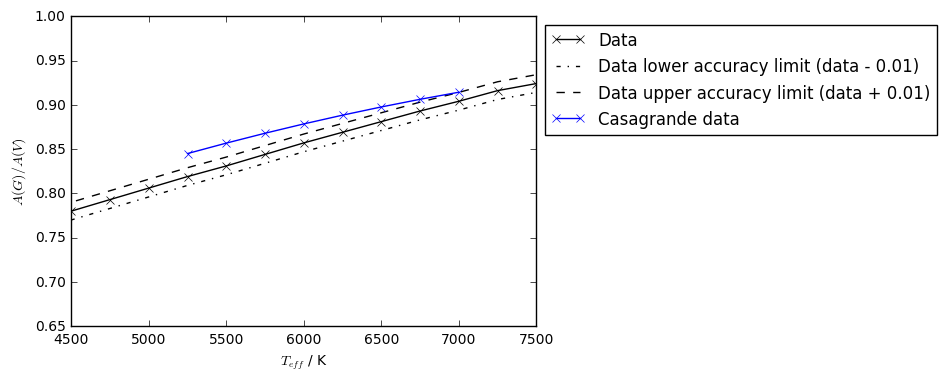


    Writing log(g)=2.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.000284456515716
Average fractional error for Power law of Teff, fitted = 0.00512735525587
Average fractional error for Power law + exponential function of Teff, fitted = 0.000463682917249
Writing complete for G filter


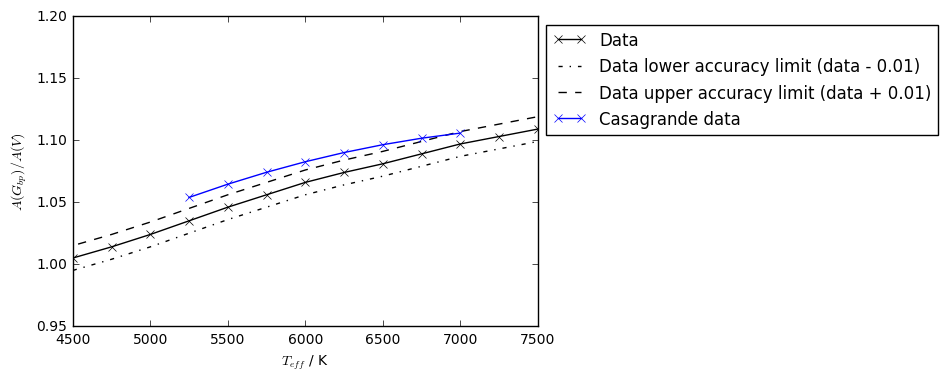


    Writing log(g)=2.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.000859484759811
Average fractional error for Power law of Teff, fitted = 0.00763047244793
Average fractional error for Power law + exponential function of Teff, fitted = 0.00154964086044
Writing complete for Gbp filter


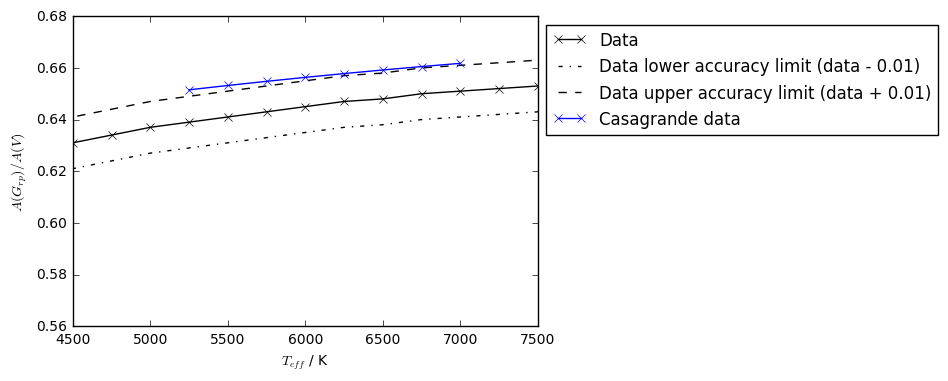


    Writing log(g)=2.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.000368906681744
Average fractional error for Power law of Teff, fitted = 0.00352220942863
Average fractional error for Power law + exponential function of Teff, fitted = 0.00035492237912
Writing complete for Grp filter

 Writing complete for log(g) = 2.0, Z = solar configuration, END OF FUNCTION WRITING!!!


'\nA_X_zs_2740_gfix\nA_X_z2_2740_gfix\n\nA_X_zs_3374_gfix\nA_X_z2_3374_gfix\n\nA_X_zs_2035_gfix\nA_X_z2_2035_gfix'

In [151]:
# GAIA FILTER PLOTTING
# filter string names
gaia_filter_str = ['G','Gbp','Grp']
# curve fitting coefficients' bounds
exp_bounds_G = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_G = ([-1.0e+05, -3., -5.], [1., 1., 5.])
plpe_bounds_G = ([-1.0e+02, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds_Gbp = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_Gbp = ([-1.0e+03, -3., -4.], [1., 3., 4.])
plpe_bounds_Gbp = ([-1.0e+02, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds_Grp = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_Grp = ([-1.0e+05, -4., -6.], [1., 4., 6.])
plpe_bounds_Grp = ([-1.0e+02, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds = [exp_bounds_G,exp_bounds_Gbp,exp_bounds_Grp]
pow_bounds = [pow_bounds_G,pow_bounds_Gbp,pow_bounds_Grp]
plpe_bounds = [plpe_bounds_G,plpe_bounds_Gbp,plpe_bounds_Grp]

#print exp_bounds
#print pow_bounds
#print plpe_bounds

# call function to general results

#metal_choice = 'sol_100'
#combined_list_coef_cov = filter_curve_fit(A_X_zs_gfix,A_X_z2_gfix,'5.0','solar',gaia_filter_str) # Leave key at '5.0'!!!
#print 'List of lists of arrays, length ',len(combined_list_coef_cov),'\n\n'
#filter_curve_plot_write(A_X_zs_gfix,A_X_z2_gfix,combined_list_coef_cov,'2.0','solar','',gaia_filter_str,'gaia_spectra','gaia_graphs','y','n',4500,7500)


In [51]:
#print combined_list_all[1]

[array([[  2.79338034e-04,   7.70976187e-08,   6.76584212e-06],
       [  7.70976187e-08,   2.57620527e-11,   3.87030584e-09],
       [  6.76584212e-06,   3.87030584e-09,   1.79492898e-06]]), array([[  2.07691944e-04,   8.88355531e-08,   8.04348948e-06],
       [  8.88355531e-08,   5.13881156e-11,   9.76299771e-09],
       [  8.04348948e-06,   9.76299771e-09,   4.84155446e-06]]), array([[  1.49136285e-05,   2.10909954e-08,   3.38301239e-07],
       [  2.10909954e-08,   3.56808576e-11,   9.52798945e-10],
       [  3.38301239e-07,   9.52798945e-10,   7.96362536e-08]])]


In [4]:
# N.B.: using cgs unit
print 'Hubble data read'
print '\n'

with open ("HubWFC/H_OUTPUT_Av0_zsolar") as Av0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_hub_data = data_read_gaia(Av0zs)

with open ("HubWFC/H_OUTPUT_Av1_zsolar") as Av1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_hub_data = data_read_gaia(Av1zs)

with open ("HubWFC/H_OUTPUT_Av0_z10-2") as Av0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_hub_data = data_read_gaia(Av0z2)

with open ("HubWFC/H_OUTPUT_Av1_z10-2") as Av1z2:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_hub_data = data_read_gaia(Av1z2)

# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'
# dictionaries
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_hub_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_hub_data,2)
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_hub_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_hub_data,2)

""""""
print '****Separating data into arrays by Teff values****'
Av0zs_Teff_fix,Av0zs_Teff_vals = grid_vals_dict(Av0zs_hub_data,1)
Av1zs_Teff_fix,Av1zs_Teff_vals = grid_vals_dict(Av1zs_hub_data,1)
Av0z2_Teff_fix,Av0z2_Teff_vals = grid_vals_dict(Av0z2_hub_data,1)
Av1z2_Teff_fix,Av1z2_Teff_vals = grid_vals_dict(Av1z2_hub_data,1)

Ahub_zs_Teff_fix = diff_grid_dict(Av0zs_Teff_fix,Av1zs_Teff_fix)
Ahub_z2_Teff_fix = diff_grid_dict(Av0z2_Teff_fix,Av1z2_Teff_fix)

print '****Finished arrays****'

A_X_zs_gfix = diff_grid_dict(Av0zs_logg_fix,Av1zs_logg_fix)
A_X_z2_gfix = diff_grid_dict(Av0z2_logg_fix,Av1z2_logg_fix)

Ahub_zs = A_X_zs_gfix
Ahub_z2 = A_X_z2_gfix

comb_dict_zs = comb_hub_gaia_dict(Ahub_zs,Agaia_zs)
comb_dict_z2 = comb_hub_gaia_dict(Ahub_z2,Agaia_z2)

# combined dictionary of arrays at fixed Teff
comb_dict_Teff_zs = comb_hub_gaia_dict(Ahub_zs_Teff_fix,Agaia_zs_Teff_fix)
comb_dict_Teff_z2 = comb_hub_gaia_dict(Ahub_z2_Teff_fix,Agaia_z2_Teff_fix)

# write out array of combined Hubble & Gaia data
#with open('AHub_vals_solar_gfix','w') as f:
#    for key in A_X_zs_gfix:
#        f.write('log(g) = ' + key + ', Z=Zsol')
#        f.write(A_X_zs_gfix[key])
        
        
print type(A_X_z2_gfix)
print type(A_X_z2_gfix['0.0'])
print comb_dict_zs['0.0'].shape
print len(comb_dict_zs)

print comb_dict_Teff_zs['5000.0'].shape
print len(comb_dict_Teff_zs)

var_names = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f218w)/A(V)$','$A(f225w)/A(V)$','$A(f275w)/A(V)$','$A(f300x)/A(V)$','$A(f336w)/A(V)$','$A(f390w)/A(V)$','$A(f438w)/A(V)$','$A(f475w)/A(V)$','$A(f555w)/A(V)$','$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$']

# 'log($T_{eff}$ / K)'

# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'
# dictionaries
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_data,2)
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_data,2)
#print Av0z2_logg_fix['5.0']
#print A_X_z2_gfix['0.0'].shape
#print (A_X_z2_gfix['0.0'])[0,:].shape

# filter string names
hub_filter_str = ['f218w','f225w','f275w','f300x','f336w','f390w','f438w','f475w','f555w','f606w','f625w','f775w','f814w']
gaia_filter_str = ['G','Gbp','Grp']
comb_filter_str = hub_filter_str + gaia_filter_str

var_names_comb = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f218w)/A(V)$','$A(f225w)/A(V)$','$A(f275w)/A(V)$','$A(f300x)/A(V)$','$A(f336w)/A(V)$','$A(f390w)/A(V)$','$A(f438w)/A(V)$','$A(f475w)/A(V)$','$A(f555w)/A(V)$','$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$']

comb_dict_zs_4500K = Teff_cutoff_fix_logg_dict(comb_dict_zs,4500.0)
comb_dict_z2_4500K = Teff_cutoff_fix_logg_dict(comb_dict_z2,4500.0)

comb_dict_zs_4000K = Teff_cutoff_fix_logg_dict(comb_dict_zs,4000.0)
comb_dict_z2_4000K = Teff_cutoff_fix_logg_dict(comb_dict_z2,4000.0)

print '4500K cutoff dict data shape: '
for key in sorted(comb_dict_zs_4500K.iterkeys()):
    print comb_dict_zs_4500K[key].shape
    
print '4000K cutoff dict data shape: '
for key in sorted(comb_dict_zs_4000K.iterkeys()):
    print comb_dict_zs_4000K[key].shape
    
print 'Variable data arrays organized'

Hubble data read



    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 15L)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476L, 15L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 15L)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 15L)
****Creating arrays****
****Separating data into arrays by log(g) values****
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
****Separating data into arrays by Teff values****
Table column  1  values list:  [3500.0, 3750.0, 4000.0, 4250.0, 4500.0, 4750.0, 5000.0, 5250.0, 5

In [7]:
# HUBBLE FILTER PLOTTING

#print comb_filter_str
"""
# curve fitting coefficients' bounds
exp_bounds_f218w = ([-100., -2., -5.], [1., 2., 5.])
pow_bounds_f218w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f218w = ([-1.0e+03, -2., -5., -1.0e+01, -1.], [1., 2., 5., 1., 1.])

exp_bounds_f225w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f225w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f225w = ([-1.0e+03, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1., 3.])

exp_bounds_f275w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f275w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f275w = ([-1.0e+02, -4., -5., -1.0e+01, -5.], [1., 4., 5., 1., 5.])

exp_bounds_f300x = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f300x = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f300x = ([-1.0e+03, -2., -3., -1.0e+01, -3.], [1., 2., 3., 1., 3.])

exp_bounds_f336w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f336w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f336w = ([-1.0e+03, -3., -3., -1.0e+01, -3.], [1., 3., 3., 1., 3.])

exp_bounds_f390w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f390w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f390w = ([-1.0e+03, -1., -5., -1.0e+01, -4.], [1., 1., 5., 1., 4.])

exp_bounds_f438w = ([-100., -1., -3.], [1., 1., 3.])
pow_bounds_f438w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f438w = ([-1.0e+03, -1., -5., -1.0e+01, -2.], [1., 1., 5., 1.0e+01, 2.])

exp_bounds_f475w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f475w = ([-1.0e+05, -2., -5.], [1., 2., 5.])
plpe_bounds_f475w = ([-1.0e+02, -1., -5., -1.0e+01, -5.], [1., 1., 5., 1., 5.])

exp_bounds_f555w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f555w = ([-1.0e+05, -3., -5.], [1., 1., 5.])
plpe_bounds_f555w = ([-1.0e+02, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1.0e+01, 3.])

exp_bounds_f606w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f606w = ([-1.0e+05, -2., -5.], [1., 2., 5.])
plpe_bounds_f606w = ([-1.0e+03, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1.0e+01, 3.])

exp_bounds_f625w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f625w = ([-1.0e+05, -3., -5.], [1., 3., 5.])
plpe_bounds_f625w = ([-1.0e+03, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1.0e+01, 3.])

exp_bounds_f775w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f775w = ([-1.0e+05, -3., -5.], [1, 3., 5.])
plpe_bounds_f775w = ([-1.0e+03, -1., -5., -1.0e+01, -5.], [1., 1., 5., 1.0e+01, 5.])

exp_bounds_f814w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f814w = ([-1.0e+05, -3., -5.], [1., 3., 5.])
plpe_bounds_f814w = ([-1.0e+02, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1.0e+01, 3.])

exp_bounds_G = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_G = ([-1.0e+05, -3., -5.], [1., 3., 5.])
plpe_bounds_G = ([-1.0e+02, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1., 3.])

exp_bounds_Gbp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Gbp = ([-1.0e+04, -3., -5.], [1., 3., 5.])
plpe_bounds_Gbp = ([-1.0e+02, -1., -3., -1.0e+01, -3.], [1., 1., 3., 1., 3.])

exp_bounds_Grp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Grp = ([-1.0e+07, -3., -5.], [1., 3., 5.])
plpe_bounds_Grp = ([-1.0e+02, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1., 3.])

# make array of bounds
exp_bounds = [exp_bounds_f218w,exp_bounds_f225w,exp_bounds_f275w,exp_bounds_f300x,exp_bounds_f336w,exp_bounds_f390w,exp_bounds_f438w,exp_bounds_f475w,exp_bounds_f555w,exp_bounds_f606w,exp_bounds_f625w,exp_bounds_f775w,exp_bounds_f814w,exp_bounds_G,exp_bounds_Gbp,exp_bounds_Grp]
pow_bounds = [pow_bounds_f218w,pow_bounds_f225w,pow_bounds_f275w,pow_bounds_f300x,pow_bounds_f336w,pow_bounds_f390w,pow_bounds_f438w,pow_bounds_f475w,pow_bounds_f555w,pow_bounds_f606w,pow_bounds_f625w,pow_bounds_f775w,pow_bounds_f814w,pow_bounds_G,pow_bounds_Gbp,pow_bounds_Grp]
plpe_bounds = [plpe_bounds_f218w,plpe_bounds_f225w,plpe_bounds_f275w,plpe_bounds_f300x,plpe_bounds_f336w,plpe_bounds_f390w,plpe_bounds_f438w,plpe_bounds_f475w,plpe_bounds_f555w,plpe_bounds_f606w,plpe_bounds_f625w,plpe_bounds_f775w,plpe_bounds_f814w,plpe_bounds_G,plpe_bounds_Gbp,plpe_bounds_Grp]

# produce fitting results - leave key at '5.0'!!!
print 'SOLAR METALLICITY FITTING'
combined_list_coef_cov_zs = filter_curve_fit(comb_dict_zs,comb_dict_z2,'5.0','solar',comb_filter_str)
print 'List of lists of arrays, length ',len(combined_list_coef_cov_zs)
print '\n'
#print '(SOLAR METALLICITY)/100 FITTING'
#combined_list_coef_cov_z2 = filter_curve_fit(comb_dict_zs,comb_dict_z2,'5.0','sol_100',comb_filter_str)
#print 'List of lists of arrays, length ',len(combined_list_coef_cov_z2),'\n\n'
"""

"\n# curve fitting coefficients' bounds\nexp_bounds_f218w = ([-100., -2., -5.], [1., 2., 5.])\npow_bounds_f218w = ([-1.0e+08, -3., -5.], [1., 3., 5.])\nplpe_bounds_f218w = ([-1.0e+03, -2., -5., -1.0e+01, -1.], [1., 2., 5., 1., 1.])\n\nexp_bounds_f225w = ([-100., -1., -5.], [1., 1., 5.])\npow_bounds_f225w = ([-1.0e+08, -3., -5.], [1., 3., 5.])\nplpe_bounds_f225w = ([-1.0e+03, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1., 3.])\n\nexp_bounds_f275w = ([-100., -1., -5.], [0., 1., 5.])\npow_bounds_f275w = ([-1.0e+08, -3., -5.], [1., 3., 5.])\nplpe_bounds_f275w = ([-1.0e+02, -4., -5., -1.0e+01, -5.], [1., 4., 5., 1., 5.])\n\nexp_bounds_f300x = ([-100., -1., -5.], [0., 1., 5.])\npow_bounds_f300x = ([-1.0e+06, -2., -5.], [1., 2., 5.])\nplpe_bounds_f300x = ([-1.0e+03, -2., -3., -1.0e+01, -3.], [1., 2., 3., 1., 3.])\n\nexp_bounds_f336w = ([-100., -1., -5.], [0., 1., 5.])\npow_bounds_f336w = ([-1.0e+08, -3., -5.], [1., 3., 5.])\nplpe_bounds_f336w = ([-1.0e+03, -3., -3., -1.0e+01, -3.], [1., 3., 3., 1

In [40]:
# 4500K Teff data cutoff HUBBLE FILTER PLOTTING

# snowballing cell

# spline interpolation

# curve fitting coefficients' bounds
exp_bounds_f218w = ([-1.0e+03, -1., -5.], [1., 1., 5.])
pow_bounds_f218w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f218w = ([-1.0e+02, -1.0e-01, -5., -1., -1.], [1., 0., 5., 1., 1.])

exp_bounds_f225w = ([-1.0e+03, -1., -5.], [1., 1., 5.])
pow_bounds_f225w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f225w = ([-1.0e+01, -1.0e-01, -5., -1.0e-01, -1.], [1., 0., 5., 1.0e-01, 1.])

exp_bounds_f275w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f275w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f275w = ([-1.0e+01, -1.0e-01, -5., -1.0e-01, -1.], [1., 0., 5., 1.0e-01, 1.])

exp_bounds_f300x = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f300x = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f300x = ([-1.0e+04, -1.0e-01, -6., -1.0e-01, -1.], [1., 0., 5., 1.0e-01, 1.])

exp_bounds_f336w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f336w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f336w = ([-1.0e+01, -1.0e-01, -6., -1.0e-01, -1.], [1., 0., 6., 1.0e-01, 1.])

exp_bounds_f390w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f390w = ([-1.0e+03, -1.0e-01, 1.], [1., 1.0e-02, 3.])
plpe_bounds_f390w = ([-1.0e+00, -1.0e-01, -3., -1.0e-01, -1.0e-01], [1., 0., 3., 1.0e-01, 1.0e-01])

exp_bounds_f438w = ([-100., -1., -3.], [1., 1., 3.])
pow_bounds_f438w = ([-1.0e+05, -2., -5.], [1., 2., 5.])
plpe_bounds_f438w = ([-1.0e+01, -1.0e-01, -5., -1.0e-01, -1.], [1., 0., 5., 1.0e-01, 1.])

exp_bounds_f475w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f475w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f475w = ([-1.0e+01, -1.0e-01, -5., -1.0e-01, -1.], [1., 1.0e-01, 5., 1.0e-01, 1.])

exp_bounds_f555w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f555w = ([-1.0e+06, -3., -5.], [1., 1., 5.])
plpe_bounds_f555w = ([-1.0e+01, -1.0e-01, -5., -1.0e-01, -1.], [1., 0., 5., 1.0e-01, 1.])

exp_bounds_f606w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f606w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f606w = ([-1.0e+01, -1.0e-01, -6., -1.0e-01, -1.], [1., 0., 6., 1.0e-01, 1.])

exp_bounds_f625w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f625w = ([-1.0e+06, -3., -5.], [1., 3., 5.])
plpe_bounds_f625w = ([-1.0e+01, -1.0e-01, -6., -1.0e-01, -1.], [1., 0., 6., 1.0e-01, 1.])

exp_bounds_f775w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f775w = ([-1.0e+05, -3., -5.], [1, 3., 5.])
plpe_bounds_f775w = ([-1.0e+01, -1.0e-01, -6., -1.0e-01, -1.], [1., 1.0e-01, 6., 1.0e-01, 1.])

exp_bounds_f814w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f814w = ([-1.0e+05, -3., -5.], [1., 3., 5.])
plpe_bounds_f814w = ([-1.0e+01, -1.0e-01, -5., -1., -1.], [1., 0., 5., 1., 1.])

exp_bounds_G = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_G = ([-1.0e+05, -3., -5.], [1., 3., 5.])
plpe_bounds_G = ([-1.0e+01, -1.0e-01, -5., -1., -1.], [1., 0., 5., 1., 1.])

exp_bounds_Gbp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Gbp = ([-1.0e+04, -3., -5.], [1., 3., 5.])
plpe_bounds_Gbp = ([-1.0e+01, -1.0e-01, -5., -1., -1.], [1., 0., 5., 1., 1.])

exp_bounds_Grp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Grp = ([-1.0e+07, -3., -5.], [1., 3., 5.])
plpe_bounds_Grp = ([-1.0e+01, -1.0e-01, -5., -1., -1.], [1., 0., 5., 1., 1.])

# make array of bounds
exp_bounds = [exp_bounds_f218w,exp_bounds_f225w,exp_bounds_f275w,exp_bounds_f300x,exp_bounds_f336w,exp_bounds_f390w,exp_bounds_f438w,exp_bounds_f475w,exp_bounds_f555w,exp_bounds_f606w,exp_bounds_f625w,exp_bounds_f775w,exp_bounds_f814w,exp_bounds_G,exp_bounds_Gbp,exp_bounds_Grp]
pow_bounds = [pow_bounds_f218w,pow_bounds_f225w,pow_bounds_f275w,pow_bounds_f300x,pow_bounds_f336w,pow_bounds_f390w,pow_bounds_f438w,pow_bounds_f475w,pow_bounds_f555w,pow_bounds_f606w,pow_bounds_f625w,pow_bounds_f775w,pow_bounds_f814w,pow_bounds_G,pow_bounds_Gbp,pow_bounds_Grp]
plpe_bounds = [plpe_bounds_f218w,plpe_bounds_f225w,plpe_bounds_f275w,plpe_bounds_f300x,plpe_bounds_f336w,plpe_bounds_f390w,plpe_bounds_f438w,plpe_bounds_f475w,plpe_bounds_f555w,plpe_bounds_f606w,plpe_bounds_f625w,plpe_bounds_f775w,plpe_bounds_f814w,plpe_bounds_G,plpe_bounds_Gbp,plpe_bounds_Grp]

# produce fitting results - leave key at '5.0'!!!
print 'SOLAR METALLICITY FITTING'
combined_list_coef_cov_zs_4500K = filter_curve_fit(comb_dict_zs_4500K,comb_dict_z2_4500K,'5.0','solar',comb_filter_str)
print 'List of lists of arrays, length ',len(combined_list_coef_cov_zs_4500K)
#print '(SOLAR METALLICITY)/100 FITTING'
#combined_list_coef_cov_z2_4500K = filter_curve_fit(comb_dict_zs_4500K,comb_dict_z2_4500K,'5.0','sol_100',comb_filter_str)
#print 'List of lists of arrays, length ',len(combined_list_coef_cov_z2_4500K),'\n\n'
#print '\n'

SOLAR METALLICITY FITTING
Calculating coefficients & covariance matrices for f218w filter
Exponential fit coefficients: 
[ -2.32428259e+02  -1.07634845e-03   2.93338391e+00]
Covariance matrix: 
[[  2.30944564e+03   2.05261468e-03   1.03582938e-01]
 [  2.05261468e-03   1.84082262e-09   1.01493353e-07]
 [  1.03582938e-01   1.01493353e-07   4.84194727e-05]]
Teff^(n) fit coefficients: 
[ -1.00000000e+08  -2.16846837e+00   3.03079547e+00]
Covariance matrix: 
[[  7.82867661e+16   9.17606751e+07   6.93045811e+06]
 [  9.17606751e+07   1.07628655e-01   8.26037789e-03]
 [  6.93045811e+06   8.26037789e-03   1.26403014e-03]]
Teff^(n) + exponential fit coefficients: 
[ -1.00000000e+02  -8.95880100e-04   2.79183763e+00   1.00000000e+00
  -1.92382308e-01]
Covariance matrix: 
[[  8.50762308e+02   2.03278041e-03   3.48060929e+01   2.26609596e+02
   -4.66006194e+01]
 [  2.03278041e-03   4.97021840e-09   9.64170621e-05   6.23624750e-04
   -1.28692534e-04]
 [  3.48060929e+01   9.64170621e-05   3.70193850e


    Writing log(g)=5.0, Z = solar model for f218w filter
Average fractional error for Exponential function of Teff, fitted = 0.00878879567624
Average fractional error for Power law of Teff, fitted = 1.3831642575
Average fractional error for Power law + exponential function of Teff, fitted = 32.7945448525

    Writing log(g)=5.0, Z = solar model for f225w filter
Average fractional error for Exponential function of Teff, fitted = 0.00239641299469
Average fractional error for Power law of Teff, fitted = 0.808095638047
Average fractional error for Power law + exponential function of Teff, fitted = 7935.31734713

    Writing log(g)=5.0, Z = solar model for f275w filter
Average fractional error for Exponential function of Teff, fitted = 0.00105540352195
Average fractional error for Power law of Teff, fitted = 0.0292078769595
Average fractional error for Power law + exponential function of Teff, fitted = 29.7444354869

    Writing log(g)=5.0, Z = solar model for f300x filter
Average fraction

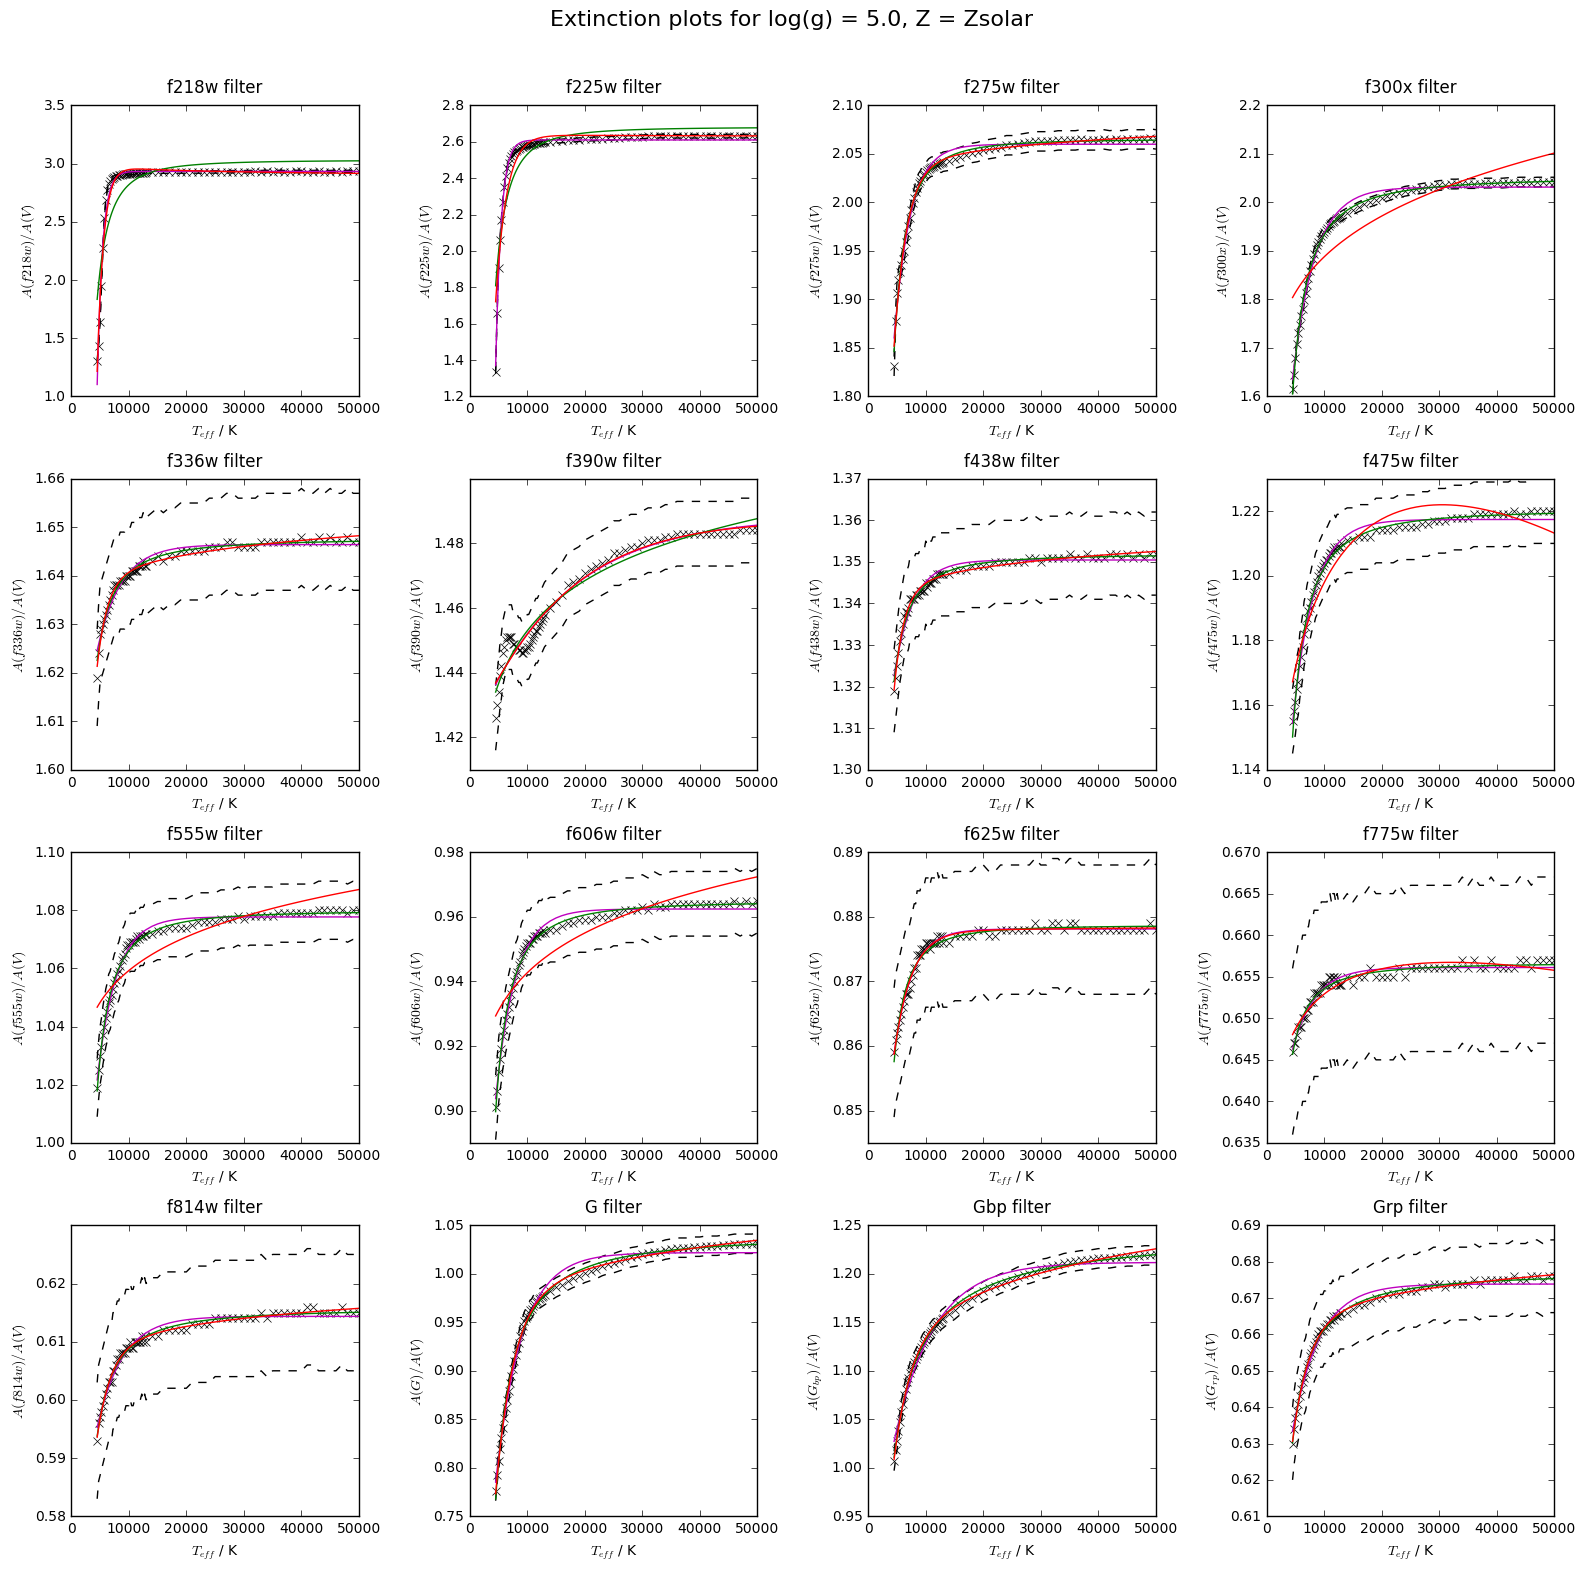


 Writing complete for log(g) = 5.0, Z = solar configuration, END OF FUNCTION WRITING!!!


In [94]:
# If finished fitting (i.e. log(g) not equal to 5.0), DON'T run previous cell!!!

# Test solar metallicity fit on BOTH metallicity scenarios
filter_curve_plot_write(comb_dict_zs_4500K,comb_dict_z2_4500K,combined_list_coef_cov_zs_4500K,'5.0','solar','4500K',comb_filter_str,'HubWFC','Hub_graphs','n','y')
#filter_curve_plot_write(comb_dict_zs_4500K,comb_dict_z2_4500K,combined_list_coef_cov_z2_4500K,'5.0','solar','4500K',comb_filter_str,'HubWFC','Hub_graphs','n','y',8000,20000)
#,4400,6000

In [25]:
#test_out_function = single_poly(comb_dict_zs_4500K['5.0'], -1.0e+05, -2., -5.)
#print test_out_function.shape
# Create coefficient summary text file for power law
# filename options:
# IN: metallicity: solar, sol_100
# OUT: metallicity: solar, solar/100
"""
print len(comb_filter_str)
make_coeffs_summary('HubWFC/','Teff_AHub_gaia_gen_fit_logg=5.0_sol_100_numbers.txt','coeffs_hub_gaia_power.txt',comb_filter_str,'5.0','solar/100','a')
"""

# low-Teff: log(g) affects A(filter)/A(V), i.e. A(Teff) becomes A(Teff,log(g))
# -> find law for log(g) effects
# N.B.: log(g) = consts. x (M(R*)/(R*)^2)
# Linear? Girardi et al. (2008) use giant Teff law: Teff(log(g)) = 3250 + 500log(g)
# For my values of log(g) (= 0 to 5), this gives a range of (3250 <= Teff <= 5750)
# Take our working definition of 0.01 'error' as a limit on log(g) effects
        
"""
with open('pred_combined_dict_example.txt','w') as f:
    for key in sorted(combined_prediction_dict_zs_4500K.iterkeys()):
        f.write('Dictionary for log(g) = ' + key + '\n')
        np.savetxt(f,combined_prediction_dict_zs_4500K[key])#,fmt='%6.1f %4.1f %6.3f %6.3f %6.3f',delimiter='   '
        f.write('\n')
    f.close()

with open('pred_Teff_dict_example.txt','w') as f:
    for key in sorted(Teff_predition_dict_zs_4500K.iterkeys()):
        f.write('Dictionary for log(g) = ' + key + '\n')
        np.savetxt(f,Teff_predition_dict_zs_4500K[key])#,fmt='%6.1f %4.1f %6.3f %6.3f %6.3f',delimiter='   '
        f.write('\n')
    f.close()

# set the Teff-value for which log(g) coefficients are calculated, using argument in function call
    # combined prediction COEFFICIENTS!
    logg_plus_Teff_pred = combined_pred_dict[logg_pred_teff_val]
    # Teff-only prediction COEFFICIENTS!
    Teff_only_pred = Teff_pred_dict[logg_pred_teff_val]

print comb_dict_zs_4500K['0.0'][0,:]
#print comb_dict_zs_4500K['0.5'][0,:]
#print combined_prediction_dict_zs_4500K['0.0'][0,:]
fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
axs = axs.ravel()
#_4500K
test_arr = comb_dict_zs['3.0']
test_arr_4500K = comb_dict_zs_4500K['3.0']
test_arr_4000K = comb_dict_zs_4000K['3.0']
for i in range(2,18):
    axs[i-2].plot(test_arr[:,0],test_arr[:,i],'r',marker='x')
    axs[i-2].plot(test_arr_4000K[:,0],test_arr_4000K[:,i],'b',marker='x')
    axs[i-2].plot(test_arr_4500K[:,0],test_arr_4500K[:,i],'g',marker='x')
plt.show()
"""

# write examples of dictionaries' formats
"""
with open('diff_dict_fixed_logg_example.txt','w') as f:
    for key in sorted(comb_logg_zs_4500K_diff.iterkeys()):
        f.write('Array for log(g) = ' + key + '\n')
        f.write('Shape: '+ str(comb_logg_zs_4500K_diff[key].shape) + '\n')
        f.write('Array has the following Teff values: ')
        for i in range(len(comb_logg_zs_4500K_diff[key][:,0])):
            f.write(str(comb_logg_zs_4500K_diff[key][i,0]) + ' ')
        f.write('\n' + str(comb_logg_zs_4500K_diff[key]) + '\n')
        f.write('\n')
    f.close()


# Fixed Teff format (to get log(g) coefficients)
with open('dict_fixed_Teff_example.txt','w') as f:#comb_Teff_zs_sort
    for key in sorted(comb_dict_Teff_zs.iterkeys()):
        if (key[0] == '0'):
            tidy_key = key[1:]
            f.write('Array for Teff = ' + tidy_key + '\n')
        else:
            f.write('Array for Teff = ' + key + '\n')
        f.write('Shape: '+ str(comb_dict_Teff_zs[key].shape) + '\n')#,' by ',str(comb_Teff_zs_sort[key].shape[1])
        f.write('Array has the following log(g) values: ')
        for i in range(len(comb_dict_Teff_zs[key][:,1])):
            f.write(str(comb_dict_Teff_zs[key][i,1]) + ' ')
        f.write('\n' + str(comb_dict_Teff_zs[key]) + '\n')
        f.write('\n')
    f.close()

# Difference dictionary for fixed Teff format data (to get log(g) coefficients)
with open('diff_dict_fixed_Teff_bounds_example.txt','w') as f:
    for key in sorted(comb_Teff_zs_sort_diff_4500_50000.iterkeys()):
        if (key[0] == '0'):
            tidy_key = key[1:]
            f.write('Array for Teff = ' + tidy_key + '\n')
        else:
            f.write('Array for Teff = ' + key + '\n')
        f.write('Shape: '+ str(comb_Teff_zs_sort_diff_4500_50000[key].shape) + '\n')#,' by ',str(comb_Teff_zs_sort[key].shape[1])
        f.write('Array has the following log(g) values: ')
        for i in range(len(comb_Teff_zs_sort_diff_4500_50000[key][:,1])):
            f.write(str(comb_Teff_zs_sort_diff_4500_50000[key][i,1]) + ' ')
        f.write('\n' + str(comb_Teff_zs_sort_diff_4500_50000[key]) + '\n')
        f.write('\n')
    f.close()
"""               

(72L, 18L)


"\nwith open('pred_combined_dict_example.txt','w') as f:\n    for key in sorted(combined_predition_dict_zs_4500K.iterkeys()):\n        f.write('Dictionary for log(g) = ' + key + '\n')\n        np.savetxt(f,combined_predition_dict_zs_4500K[key])#,fmt='%6.1f %4.1f %6.3f %6.3f %6.3f',delimiter='   '\n        f.write('\n')\n    f.close()\n\nwith open('pred_Teff_dict_example.txt','w') as f:\n    for key in sorted(Teff_predition_dict_zs_4500K.iterkeys()):\n        f.write('Dictionary for log(g) = ' + key + '\n')\n        np.savetxt(f,Teff_predition_dict_zs_4500K[key])#,fmt='%6.1f %4.1f %6.3f %6.3f %6.3f',delimiter='   '\n        f.write('\n')\n    f.close()\n\n# set the Teff-value for which log(g) coefficients are calculated, using argument in function call\n    # combined prediction COEFFICIENTS!\n    logg_plus_Teff_pred = combined_pred_dict[logg_pred_teff_val]\n    # Teff-only prediction COEFFICIENTS!\n    Teff_only_pred = Teff_pred_dict[logg_pred_teff_val]\n\nprint comb_dict_zs_4500K['0.0

In [87]:
var_names_comb = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f218w)/A(V)$','$A(f225w)/A(V)$','$A(f275w)/A(V)$','$A(f300x)/A(V)$','$A(f336w)/A(V)$','$A(f390w)/A(V)$','$A(f438w)/A(V)$','$A(f475w)/A(V)$','$A(f555w)/A(V)$','$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$']
best_fits_filterwise = ['exp','exp','exp','pow','pow','pow','pow','pow','pow','pow','pow','pow','pow','pow','pow','pow']
print len(best_fits_filterwise)
#comb_dict_zs_4500K = Teff_cutoff_fix_logg_dict(comb_dict_zs,4500.0)
# solar metallicity
comb_Teff_zs_sort = {}
# difference dictionary with log(g) as a reference
comb_Teff_zs_sort_diff = {}
comb_logg_zs_4500K_diff = {}

# solar/100 metallicity
comb_Teff_z2_sort = {}
# difference dictionary with log(g) as a reference
comb_Teff_z2_sort_diff = {}
comb_logg_z2_4500K_diff = {}

# Combining the two effects
# Teff-only coefficients lists
exp_Teff_coef_4500K_logg_5 = combined_list_coef_cov_zs_4500K[0]
exp_Teff_covar_4500K_logg_5 = combined_list_coef_cov_zs_4500K[1]
pow_Teff_coef_4500K_logg_5 = combined_list_coef_cov_zs_4500K[2]
pow_Teff_covar_4500K_logg_5 = combined_list_coef_cov_zs_4500K[3]
plpe_Teff_coef_4500K_logg_5 = combined_list_coef_cov_zs_4500K[4]
plpe_Teff_covar_4500K_logg_5 = combined_list_coef_cov_zs_4500K[5]

# Following line gives: number of filters, number of coeffs for function (apply to each filter)
# Total number of Teff-only curves produced earlier = 16x3 = 48 -> 48 sets of coefficients, 48 covariance matrices
print len(exp_Teff_coef_4500K_logg_5),len(exp_Teff_coef_4500K_logg_5[0])

#comb_dict_z2_4500K = Teff_cutoff_fix_logg_dict(comb_dict_z2,4500.0)

# properly ordered sorting for  Teff-keyed data
for old_key in comb_dict_Teff_zs:
    new_key = old_key.zfill(7)
    comb_Teff_zs_sort[new_key] = np.copy(comb_dict_Teff_zs[old_key])
    comb_Teff_z2_sort[new_key] = np.copy(comb_dict_Teff_z2[old_key])

# dictionaries of difference values from log(g) = 5.0
comb_Teff_zs_sort_diff = diff_from_ref_Teff_key(comb_Teff_zs_sort)
comb_Teff_z2_sort_diff = diff_from_ref_Teff_key(comb_Teff_z2_sort)

comb_logg_zs_4500K_diff = diff_from_ref_logg_key(comb_dict_zs_4500K)
comb_logg_z2_4500K_diff = diff_from_ref_logg_key(comb_dict_z2_4500K)

#print len(comb_Teff_zs_sort_diff)
comb_Teff_zs_sort_diff_4500_50000 = Teff_cutoff_fix_Teff_dict(comb_Teff_zs_sort_diff,4500.0,50000.0)
comb_Teff_z2_sort_diff_4500_50000 = Teff_cutoff_fix_Teff_dict(comb_Teff_z2_sort_diff,4500.0,50000.0)

# Function to plot multiple Teff or log(g) lines (for 1 filter output ONLY!)
# Input: dictionary of relevant arrays, pyplot axes name (text),fixed input variable values (list of strings)

quad_bounds = ([-5.,-5.,-10.],[5.,5.,10.])
""" REMEMBER THE FUNCTION'S FORM!
    def Teff_logg_product_func(Tdata,gdata,a,b,c):
        y = a*(Tdata*gdata) + b*gdata + c
        return y"""
Tlgp_bounds = ([0.,-1.,-1.],[1.0e-04,1.,1.])

# add extra Teff effect to log(g) functions using new function
logg_coeffs_dict_zs_Teff_4500,logg_cov_dict_zs_Teff_4500 = logg_coeffs_calc('coeffs_logg_zs_4500_50000.txt',comb_Teff_zs_sort_diff_4500_50000,quad_func,quad_bounds,comb_filter_str)
print 'Syncing the log(g)-only functions with main (Teff-only) function'

comb_R2_coeffs_dict_zs_Teff_4500,comb_R2_cov_dict_zs_Teff_4500 = Teff_and_logg_combined_coeffs_calc('coeffs_comb_R2_zs_4500_50000.txt',comb_logg_zs_4500K_diff,Teff_logg_product_func,Tlgp_bounds,comb_filter_str,'0.0')
print 'Syncing the combined Teff-log(g) functions with main (Teff-only) function'
    
# Carry out syncing
logg_Avals_pred_dict_zs_4500K,Teff_logg_Avals_pred_dict_zs_4500K = combined_effects_grid_sync(comb_dict_zs_4500K,logg_coeffs_dict_zs_Teff_4500,'04500.0',best_fits_filterwise)
print 'Finished log(g)-only sync'
combined_Avals_pred_dict_zs_4500K,Teff_comb_Avals_pred_dict_zs_4500K = combined_effects_grid_sync(comb_dict_zs_4500K,comb_R2_coeffs_dict_zs_Teff_4500,'04500.0',best_fits_filterwise)
print 'Finished Teff-log(g) combination sync'

print len(comb_dict_zs_4500K),' , ',len(combined_Avals_pred_dict_zs_4500K)
print (comb_dict_zs_4500K['5.0']).shape,' , ',(combined_Avals_pred_dict_zs_4500K['5.0']).shape

# Note: len(logg_coeffs_dict_zs_Teff_4500['04500.0']) = 16!!!
print type(logg_coeffs_dict_zs_Teff_4500['04500.0'][0])
print logg_coeffs_dict_zs_Teff_4500['04500.0'][0]
print len(logg_coeffs_dict_zs_Teff_4500)
print len((comb_dict_zs_4500K['5.0'])[:,0])

#for key in sorted(comb_Teff_zs_sort_diff_4500_50000.iterkeys()):
#    print key,type(key)

print (comb_Teff_zs_sort_diff_4500_50000)['04500.0'].shape
Teff_vals_arr = from_keys_get_numerical_data(comb_Teff_zs_sort_diff_4500_50000)
print Teff_vals_arr
logg_vals_arr = from_keys_get_numerical_data(comb_dict_zs_4500K)
print logg_vals_arr

print 'combined stuff working SO FAR!!!'

16
16 3
Dictionary size (number of Teff values, full dictionary then cutoff-limited): 
76 72
Dictionary size (number of Teff values, full dictionary then cutoff-limited): 
76 72
Syncing the log(g)-only functions with main (Teff-only) function
Syncing the combined Teff-log(g) functions with main (Teff-only) function
Teff-matching results between Teff & log(g) dictionaries:  0
Finished log(g)-only sync
Teff-matching results between Teff & log(g) dictionaries:  11
Finished Teff-log(g) combination sync
11  ,  11
(72L, 18L)  ,  (72L, 18L)
<type 'numpy.ndarray'>
[ 0.  0.  0.]
72
72
(11L, 18L)
Array of key values:  (72L,)
[  4500.   4750.   5000.   5250.   5500.   5750.   6000.   6250.   6500.
   6750.   7000.   7250.   7500.   7750.   8000.   8250.   8500.   8750.
   9000.   9250.   9500.   9750.  10000.  10250.  10500.  10750.  11000.
  11250.  11500.  11750.  12000.  12250.  12500.  12750.  13000.  14000.
  15000.  16000.  17000.  18000.  19000.  20000.  21000.  22000.  23000.
  24000.  25

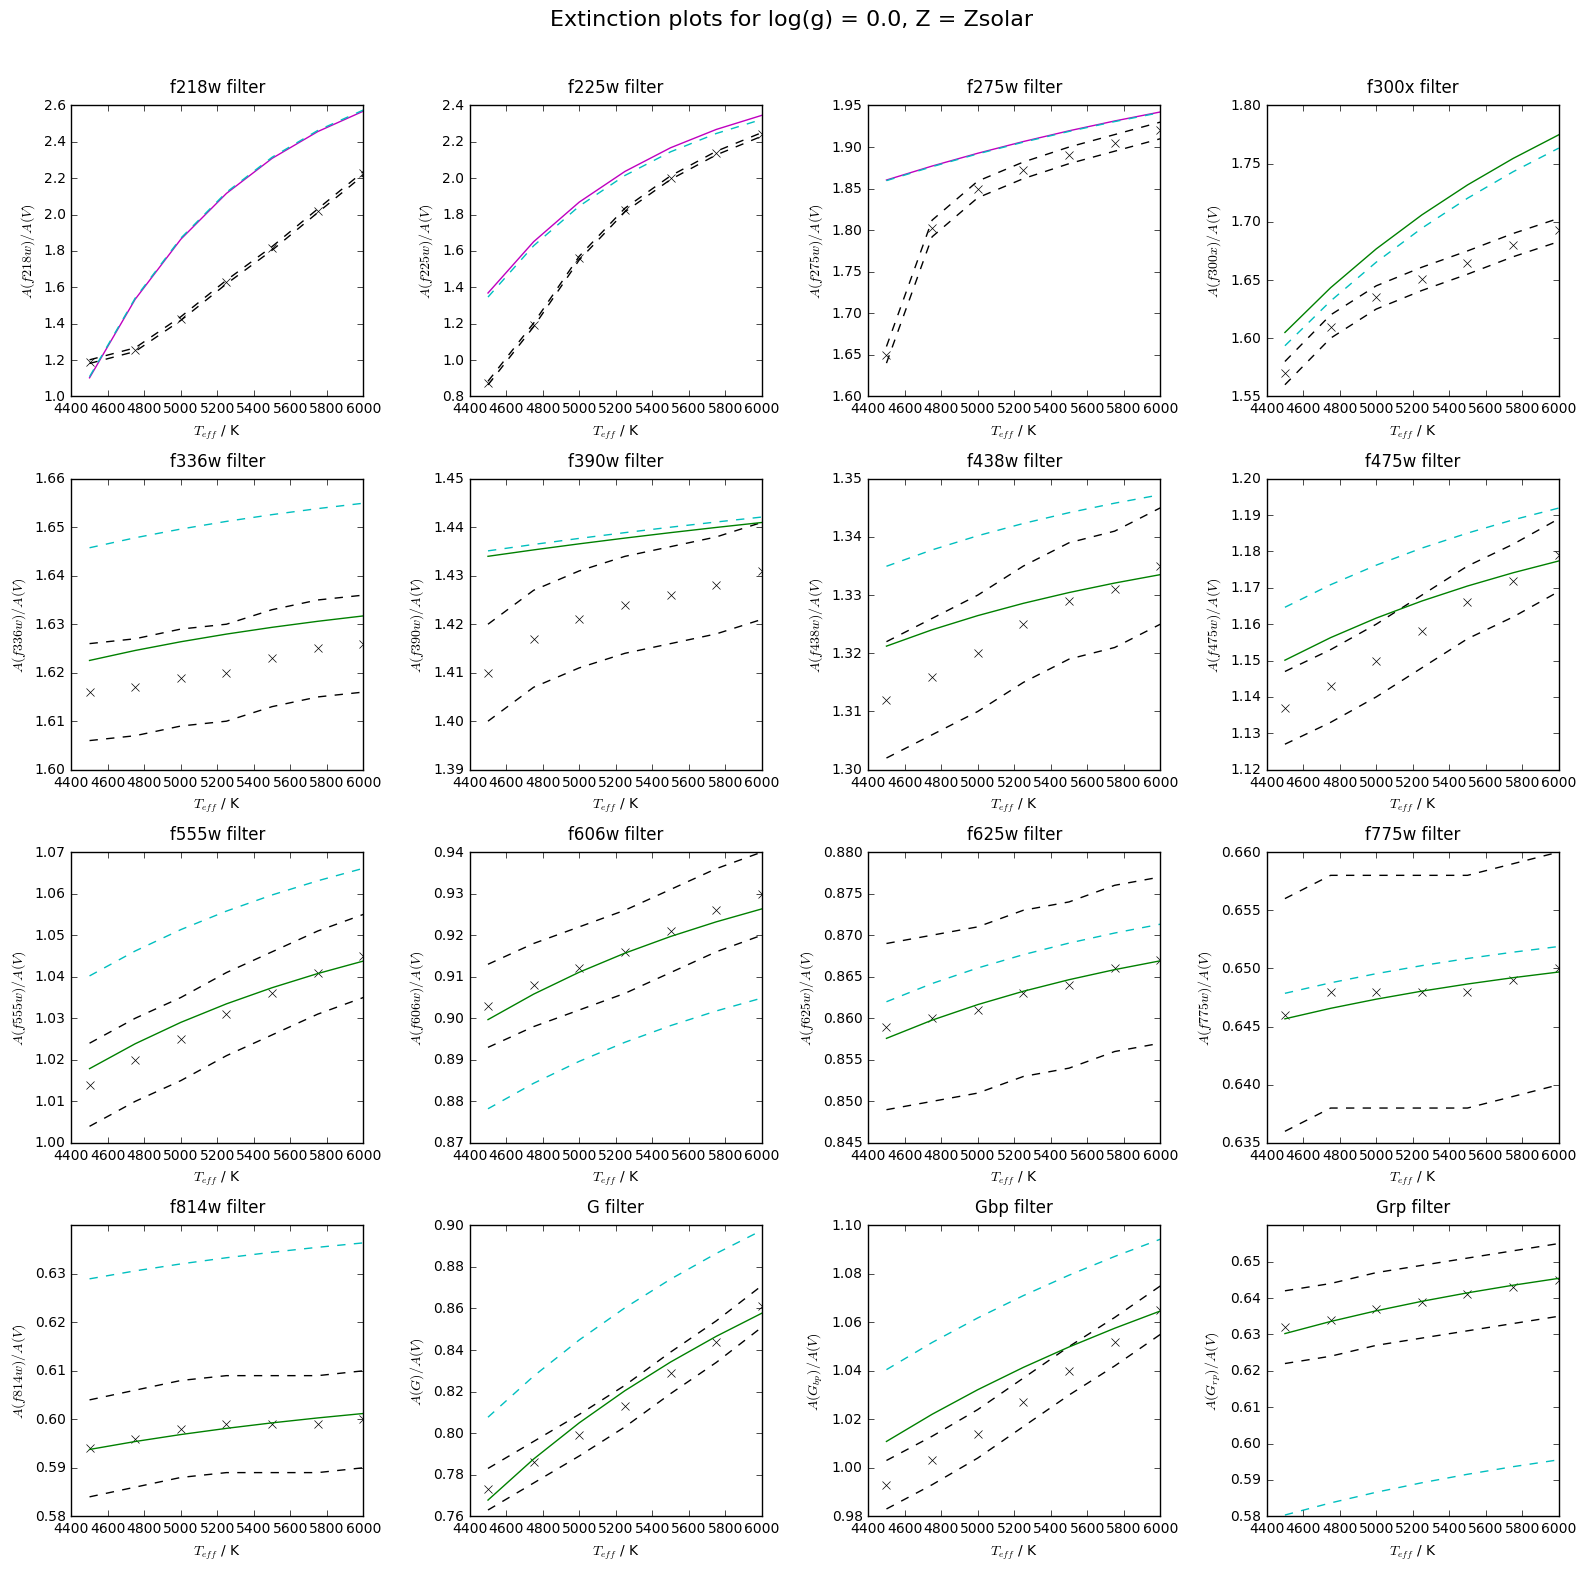


 Writing complete for log(g)-corrected Teff functions for log(g) = 0.0, Z = solar

 Writing complete for log(g)-corrected Teff functions for log(g) = 0.5, Z = solar

 Writing complete for log(g)-corrected Teff functions for log(g) = 1.0, Z = solar

 Writing complete for log(g)-corrected Teff functions for log(g) = 1.5, Z = solar

 Writing complete for log(g)-corrected Teff functions for log(g) = 2.0, Z = solar

 Writing complete for log(g)-corrected Teff functions for log(g) = 2.5, Z = solar

 Writing complete for log(g)-corrected Teff functions for log(g) = 3.0, Z = solar

 Writing complete for log(g)-corrected Teff functions for log(g) = 3.5, Z = solar

 Writing complete for log(g)-corrected Teff functions for log(g) = 4.0, Z = solar

 Writing complete for log(g)-corrected Teff functions for log(g) = 4.5, Z = solar

 Writing complete for log(g)-corrected Teff functions for log(g) = 5.0, Z = solar

 Writing complete for log(g)-corrected Teff functions, Z = solar configuration, END OF

In [90]:
# FINAL WRITING-OUT CELL!!!!
combined_effects_plot_write(comb_dict_zs_4500K,Teff_comb_Avals_pred_dict_zs_4500K,combined_Avals_pred_dict_zs_4500K,'solar','HubWFC','Hub_graphs','4500K_combined_TG',comb_filter_str,best_fits_filterwise)#,4500,10000)
print 'END OF FINAL WRITE-OUT!!!'

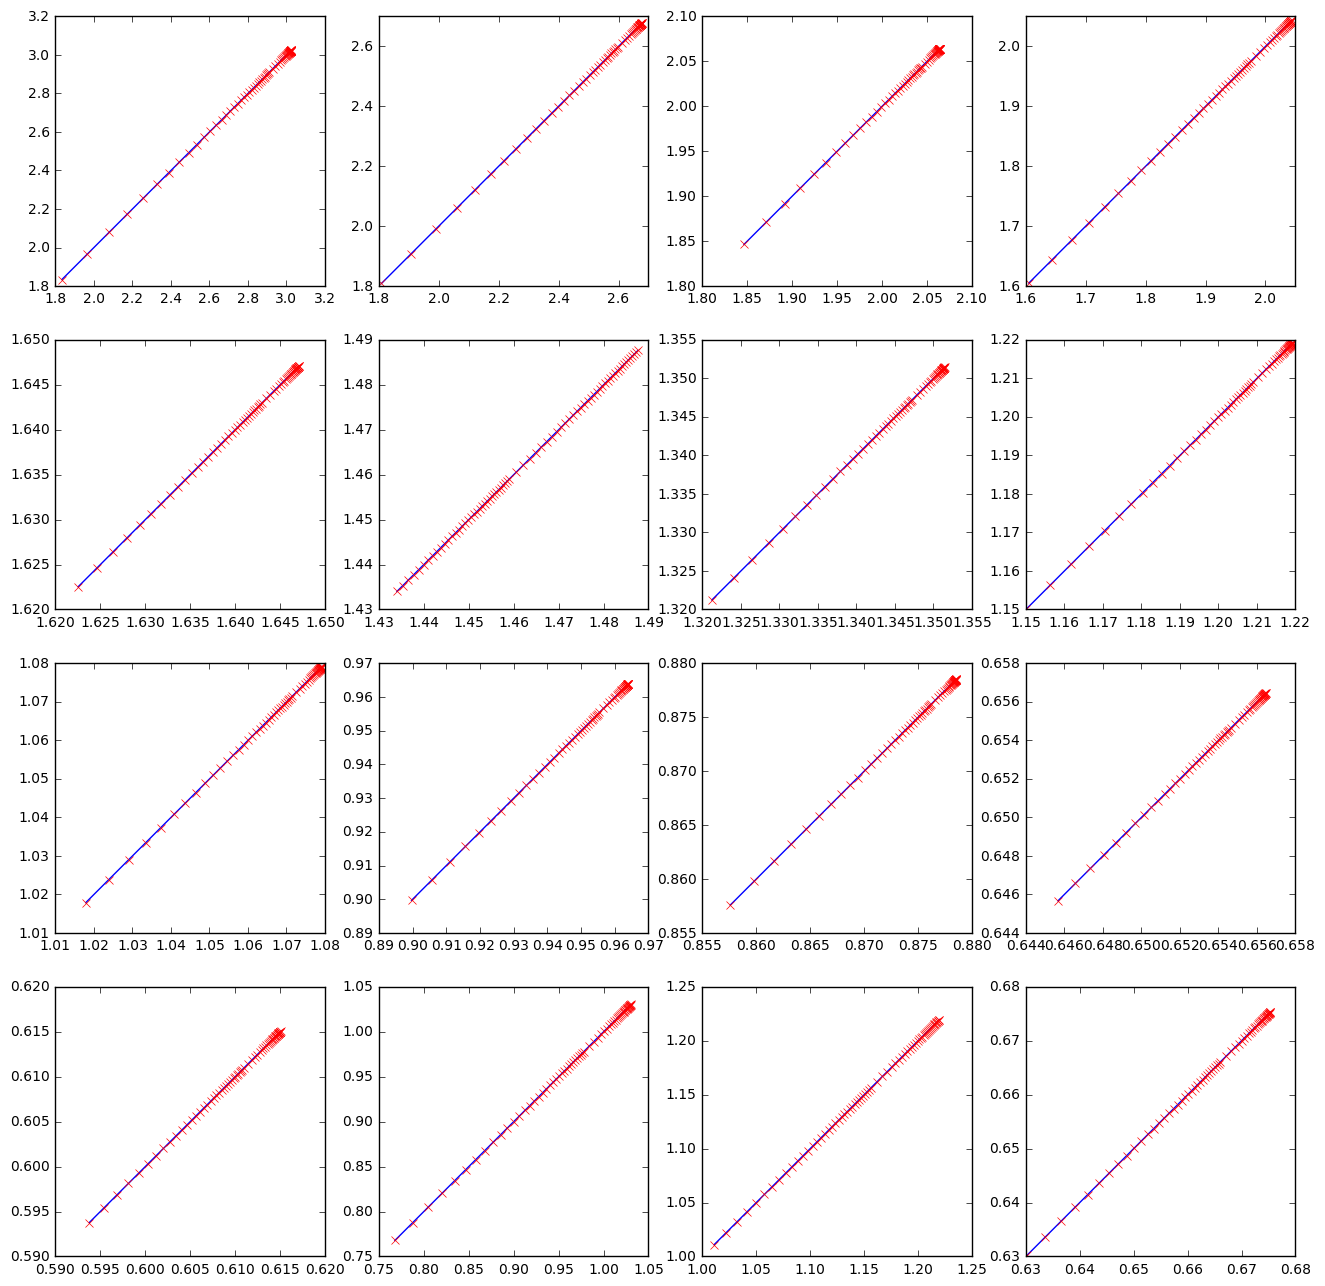

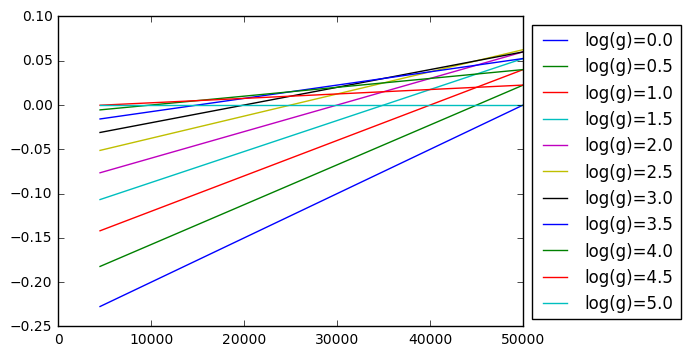

In [29]:
fig,chax = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
chax = chax.ravel()
key = '5.0'
for i in range(2,18):
    chax[i-2].plot((Teff_comb_Avals_pred_dict_zs_4500K[key])[:,i],(Teff_logg_Avals_pred_dict_zs_4500K[key])[:,i],'b')
    chax[i-2].plot((Teff_comb_Avals_pred_dict_zs_4500K[key])[:,i],(Teff_comb_Avals_pred_dict_zs_4500K[key])[:,i],'r',marker='x',linestyle='')

ylist = []
for g in logg_vals_arr:
    y = Teff_logg_product_func(Teff_vals_arr,(5.0-g),0.000001,-0.01,0.0)
    ylist.append(y)

fig,ax = plt.subplots()
for g in range(len(logg_vals_arr)):
    yarr = np.array(ylist[g])
    ax.plot(Teff_vals_arr,yarr,label=('log(g)=' + str(logg_vals_arr[g])))
#ax.set_ylim(0.3,4.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

In [11]:
print 'logg results storage size:'
print len(logg_coeffs_stored),len(logg_coeffs_stored[0])
for i in logg_coeffs_stored:
    print i

logg results storage size:
16 3
[-0.00074592  0.02656597 -0.11425175]
[-0.01537529  0.17502191 -0.48683916]
[-0.01082517  0.08743497 -0.1755035 ]
[-0.00420047  0.03000233 -0.04652448]
[-0.00070862  0.00423403 -0.00347552]
[-0.00103496  0.00841119 -0.01606294]
[-0.00054545  0.00412727 -0.00709091]
[-0.00035897  0.00548578 -0.0183007 ]
[-0.00063869  0.00404802 -0.00453147]
[-0.0004662   0.00178555  0.00252448]
[ -4.19580420e-05   1.91608392e-04  -2.09790210e-05]
[ 0.  0.  0.]
[ -6.99300699e-05   2.22377622e-04   1.14685315e-03]
[-0.00098368  0.00555478 -0.00300699]
[-0.0011049   0.00852448 -0.01437063]
[  3.26340326e-05  -4.35897436e-04   1.62237762e-03]


"\n# plot all 3 filters against Teff together\nfig,ax = plt.subplots()\nax.set_xlabel(var_names[0])\nax.set_ylabel('A(filter)')\nax.plot(Teff_5_zs,A_G_5_zs,'g', label = 'log(g) = 5, $A(G)$ curve')\nax.plot(Teff_5_zs,A_Gbp_5_zs,'b', label = 'log(g) = 5, $A(G_{bp})$ curve')\nax.plot(Teff_5_zs,A_Grp_5_zs,'r', label = 'log(g) = 5, $A(G_{rp})$ curve')\nplt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))\nplt.show()\n#fig.savefig('gaia_spectra/gaia_graphs/Aall_vs_Teff.pdf', bbox_inches='tight')\n"

In [53]:
"""
# plot all 3 filters against Teff together
fig,ax = plt.subplots()
ax.set_xlabel(var_names[0])
ax.set_ylabel('A(filter)')
ax.plot(Teff_5_zs,A_G_5_zs,'g', label = 'log(g) = 5, $A(G)$ curve')
ax.plot(Teff_5_zs,A_Gbp_5_zs,'b', label = 'log(g) = 5, $A(G_{bp})$ curve')
ax.plot(Teff_5_zs,A_Grp_5_zs,'r', label = 'log(g) = 5, $A(G_{rp})$ curve')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
#fig.savefig('gaia_spectra/gaia_graphs/Aall_vs_Teff.pdf', bbox_inches='tight')


if (col_x == 1):
                    f.write('Filter ratio (y-axis): ' + var_names[i] + '\n')
                    f.write('Fixed parameter: log(g) = ' + i + '\n')
                    f.write('Quadratic fit coefficients: \n')
                    f.write(str(coeffs)+'\n')
                    f.write('Covariance: \n')
                    f.write(str(cov_mat)+'\n')
                    f.write('\n')
                    f.close()
                elif (col_x == 2):"""
"""
exp_fit_A_logg5, covarr_A_logg5_ef = curve_fit(exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-5.], [0., 1., 5.]))
pow_fit_A_logg5, covarr_A_logg5_pow = curve_fit(single_poly,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.0e+08,-5.,-3.], [1., 1., 4.]))
spp_exp_fit_A_logg5, covarr_A_logg5_spp = curve_fit(single_poly_plus_exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-4.,-5.], [1.,1.,2.,1.]))
#log_fit_A_logg5, covarr_A_logg5_lf = curve_fit(log_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.,5.0e-07,-5.], [10., 10., 5.]))

fig, ax = plt.subplots()
ax.set_xlabel(var_names[0])
ax.set_ylabel(var_names[4])

ax.plot((A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4],'k',label='Data')
ax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
ax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
ax.plot((A_X_zs_gfix['5.0'])[:,0],exp_func((A_X_zs_gfix['5.0'])[:,0],*exp_fit_A_logg5),'m',label=fit_types[0])
ax.plot((A_X_zs_gfix['5.0'])[:,0],single_poly((A_X_zs_gfix['5.0'])[:,0],*pow_fit_A_logg5),'g',label=fit_types[1])
ax.plot((A_X_zs_gfix['5.0'])[:,0],single_poly_plus_exp_func((A_X_zs_gfix['5.0'])[:,0],*spp_exp_fit_A_logg5),'r',label=fit_types[2])

#ax.set_xlim(3000,10000)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('gaia_spectra/gaia_graphs/AGrp_logg=5.0_Teff_fit_plot.pdf', bbox_inches='tight')



def low_logg_law_trunc(whole_dict,err_lim):
    # use log(g)-keyed dictionaries to save memory
    # get log(g) = 5 dictionary (the one the model is fitted to) as the reference data
    a = whole_dict['5.0']
    for key in sorted(whole_dict.iterkeys()):
        k = ''
        if (key != '5.0'):
            b = whole_dict[key]
                # find the range for which data spread greater than 0.01   
            for i in range(len(b[:,0])): # row number iteration
                x = 0
                for j in range(2,len(b[0,:])): # column number iteration
                    if (x != 0):
                        k = '\t'
                    # data spread condition
                    dif = a[i,j]-b[i,j]
                    if (abs(dif) >= err_lim):
                        print k + 'Teff=',b[i,0],', log(g)=',b[i,1],', column ',(j+1),', difference=',dif
                        k = ''
                        x += 1

#print ' \t Full-Data Dictionary'
#low_logg_law_trunc(comb_dict_zs,0.01)
#print '\n \t Teff >= 4500K Data Dictionary'
#low_logg_law_trunc(comb_dict_zs_4500K,0.01)
"""

"\nexp_fit_A_G5zs, covarr_A_G5zs_ef = curve_fit(exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-5.], [0., 1., 5.]))\npow_fit_A_G5zs, covarr_A_G5zs_pow = curve_fit(single_poly,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.0e+08,-5.,-3.], [1., 1., 4.]))\nspp_exp_fit_A_G5zs, covarr_A_G5zs_spp = curve_fit(single_poly_plus_exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-4.,-5.], [1.,1.,2.,1.]))\n#log_fit_A_G5zs, covarr_A_G5zs_lf = curve_fit(log_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.,5.0e-07,-5.], [10., 10., 5.]))\n\nfig, ax = plt.subplots()\nax.set_xlabel(var_names[0])\nax.set_ylabel(var_names[4])\n\nax.plot((A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4],'k',label='Data')\nax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] - 0.01),'k',linestyle='-.',label='Data lower accuracy limi

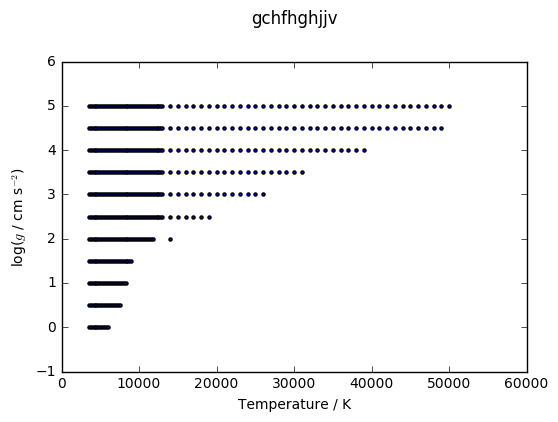

In [44]:
fig, ax = plt.subplots()
#ax.axhline(y=5.0, color='m', linestyle='--')
# Create a continuous norm to map from data points to colors | np.log10((Dthm+1).min()),np.log10((Dthm+1).max())
ax.scatter(T_Av0zs,log_g_Av0zs,marker='.')
ax.set_xlabel('Temperature / K')
ax.set_ylabel('log($g$ / cm s$^{-2}$)')
#ax.set_xlim(['5.02, 0.1])
#ax.set_ylim([0, 0.1])
#plt.show()
#ax.set_title('gchfhghjjv', y=1.1)
fig.savefig('gaia_spectra/gaia_graphs/hgchgftf.pdf', bbox_inches='tight')